In [263]:
#standard ds imports
import pandas as pd
import numpy as np

#viz and stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

import os
import env

from sklearn.model_selection import train_test_split

# Acquire

In [139]:
def get_connection(db: str, user: str = env.user, host: str = env.host, password=env.password) -> str: # add to wrangle file 
    return f"mysql+pymysql://{user}:{password}@{host}/{db}"


In [140]:
def get_zillow_data(file_name="zillow.csv") -> pd.DataFrame: # add to wrangle file 
    if os.path.isfile(file_name):
        return pd.read_csv(file_name)
    query = """select propertylandusedesc, bedroomcnt, 
               bathroomcnt, calculatedfinishedsquarefeet, 
               taxvaluedollarcnt, yearbuilt, taxamount, fips
               from propertylandusetype 
               join properties_2017
               using (propertylandusetypeid)
               where propertylandusedesc = 'Single Family Residential'
            """
    connection = get_connection("zillow")
    df = pd.read_sql(query, connection)
    df.to_csv(file_name, index=False)
    return df

In [141]:
df = get_zillow_data()
df.head(3) # first look at the data 

,propertylandusedesc,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,Single Family Residential,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,Single Family Residential,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,Single Family Residential,0.0,0.0,NaN,10.0,NaN,NaN,6037.0


# Prepare

In [142]:
df.info() # viewing the data types 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152863 entries, 0 to 2152862
Data columns (total 8 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   propertylandusedesc           object 
 1   bedroomcnt                    float64
 2   bathroomcnt                   float64
 3   calculatedfinishedsquarefeet  float64
 4   taxvaluedollarcnt             float64
 5   yearbuilt                     float64
 6   taxamount                     float64
 7   fips                          float64
dtypes: float64(7), object(1)
memory usage: 131.4+ MB


In [143]:
df.describe().T # viewing descriptive statistics 

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,2152852.0,3.287196,0.954754,0.00,3.00,3.00,4.00,25.00
bathroomcnt,2152852.0,2.230688,0.999280,0.00,2.00,2.00,3.00,32.00
calculatedfinishedsquarefeet,2144379.0,1862.855178,1222.125124,1.00,1257.00,1623.00,2208.00,952576.00
taxvaluedollarcnt,2152370.0,461896.237963,699676.049600,1.00,188170.25,327671.00,534527.00,98428909.00
yearbuilt,2143526.0,1960.949681,22.162196,1801.00,1949.00,1958.00,1976.00,2016.00
taxamount,2148421.0,5634.865978,8178.910249,1.85,2534.98,4108.95,6414.32,1337755.86
fips,2152863.0,6048.377335,20.433292,6037.00,6037.00,6037.00,6059.00,6111.00


In [144]:
df = df.rename(columns = {'bedroomcnt':'bed_rooms', 'bathroomcnt':'bath_rooms', 'calculatedfinishedsquarefeet':'finished_sqft', 
                          'taxvaluedollarcnt':'tax_value', 'fips':'county', 'yearbuilt': 'year_built', 'taxamount': 'tax_amount'})

df.head(3) # renamed columns for better understanding 

,propertylandusedesc,bed_rooms,bath_rooms,finished_sqft,tax_value,year_built,tax_amount,county
0,Single Family Residential,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,Single Family Residential,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,Single Family Residential,0.0,0.0,NaN,10.0,NaN,NaN,6037.0


In [145]:
df.isnull().sum() # can see how many null values per column  

propertylandusedesc       0
bed_rooms                11
bath_rooms               11
finished_sqft          8484
tax_value               493
year_built             9337
tax_amount             4442
county                    0
dtype: int64

In [146]:
df.isnull().mean() # can see the percentage of null values per columns 

propertylandusedesc    0.000000
bed_rooms              0.000005
bath_rooms             0.000005
finished_sqft          0.003941
tax_value              0.000229
year_built             0.004337
tax_amount             0.002063
county                 0.000000
dtype: float64

In [147]:
df = df.dropna() # dropping all null values because every null made up less than one percent of thier respective column. 
                 # our dataset is large so dropping then will not infuance our data significatly  

df.isnull().sum()

propertylandusedesc    0
bed_rooms              0
bath_rooms             0
finished_sqft          0
tax_value              0
year_built             0
tax_amount             0
county                 0
dtype: int64

In [148]:
make_ints = ['bed_rooms', 'finished_sqft', 'tax_value', 'year_built', 'county'] 

for col in make_ints:
    df[col] = df[col].astype(int)

df.info() # convert floats into ints 

<class 'pandas.core.frame.DataFrame'>
Index: 2140235 entries, 4 to 2152862
Data columns (total 8 columns):
 #   Column               Dtype  
---  ------               -----  
 0   propertylandusedesc  object 
 1   bed_rooms            int64  
 2   bath_rooms           float64
 3   finished_sqft        int64  
 4   tax_value            int64  
 5   year_built           int64  
 6   tax_amount           float64
 7   county               int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 147.0+ MB


In [149]:
df.head(3)

,propertylandusedesc,bed_rooms,bath_rooms,finished_sqft,tax_value,year_built,tax_amount,county
4,Single Family Residential,4,2.0,3633,296425,2005,6941.39,6037
6,Single Family Residential,3,4.0,1620,847770,2011,10244.94,6037
7,Single Family Residential,3,2.0,2077,646760,1926,7924.68,6037


In [150]:
def wrangle_zillow(df: pd.DataFrame) -> pd.DataFrame: # add to wrangle file 
    '''
    This function takes in a dataframe
    renames the columns and drops nulls values
    Additionally it changes datatypes for appropriate columns.
    Then returns a cleaned dataframe
    '''
    df = df.rename(columns = {'bedroomcnt':'bed_rooms', 'bathroomcnt':'bath_rooms', 'calculatedfinishedsquarefeet':'finished_sqft', 
                          'taxvaluedollarcnt':'tax_value', 'fips':'county', 'yearbuilt': 'year_built', 'taxamount': 'tax_amount'})
    
    df = df.dropna()
    
    make_ints = ['bed_rooms','finished_sqft','tax_value','year_built', 'county']

    for col in make_ints:
        df[col] = df[col].astype(int)
        
    return df


### testing out the function 

In [151]:
new_df = get_zillow_data()
new_df.head(3) # get fresh data to test 

,propertylandusedesc,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,Single Family Residential,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,Single Family Residential,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,Single Family Residential,0.0,0.0,NaN,10.0,NaN,NaN,6037.0


In [152]:
wrangle_zillow(new_df) # verify 

,propertylandusedesc,bed_rooms,bath_rooms,finished_sqft,tax_value,year_built,tax_amount,county
4,Single Family Residential,4,2.0,3633,296425,2005,6941.39,6037
6,Single Family Residential,3,4.0,1620,847770,2011,10244.94,6037
7,Single Family Residential,3,2.0,2077,646760,1926,7924.68,6037
11,Single Family Residential,0,0.0,1200,5328,1972,91.60,6037
14,Single Family Residential,0,0.0,171,6920,1973,255.17,6037
...,...,...,...,...,...,...,...,...
2152856,Single Family Residential,4,4.0,4375,422400,2015,13877.56,6037
2152858,Single Family Residential,4,3.0,2262,960756,2015,13494.52,6059
2152859,Single Family Residential,4,4.5,3127,536061,2014,6244.16,6059
2152861,Single Family Residential,3,2.5,1974,424353,2015,5302.70,6059


In [153]:
def get_all_zillow_data(file_name="zillow_all.csv") -> pd.DataFrame: # add to wrangle file 
    if os.path.isfile(file_name):
        return pd.read_csv(file_name)
    query = """select propertylandusedesc, parcelid, bedroomcnt, 
bathroomcnt, calculatedfinishedsquarefeet, 
taxvaluedollarcnt, yearbuilt, taxamount, fips, 
logerror, transactiondate
from propertylandusetype 
left join properties_2017
using (propertylandusetypeid)
left join predictions_2017
using(parcelid)
where propertylandusedesc = 'Single Family Residential';
            """
    connection = get_connection("zillow")
    df = pd.read_sql(query, connection)
    df.to_csv(file_name, index=False)
    return df

# second dataframe 

In [154]:
def get_zillow_data(file_name="zillow_all.csv") -> pd.DataFrame: # add to wrangle file 
    if os.path.isfile(file_name):
        return pd.read_csv(file_name)
    query = """select propertylandusedesc, parcelid, bedroomcnt, 
               bathroomcnt, calculatedfinishedsquarefeet, 
               taxvaluedollarcnt, yearbuilt, taxamount, fips, 
               logerror, transactiondate
               from propertylandusetype 
               left join properties_2017
               using (propertylandusetypeid)
               left join predictions_2017
               using(parcelid)
               where propertylandusedesc = 'Single Family Residential';
            """
    connection = get_connection("zillow")
    df = pd.read_sql(query, connection, parse_dates=['transactiondate'])
    df.to_csv(file_name, index=False)
    return df

In [155]:
zillow_df = get_zillow_data()

zillow_df.head(3)

,propertylandusedesc,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips,logerror,transactiondate
0,Single Family Residential,11007640,3.0,2.0,1572.0,305307.0,1976.0,3887.80,6037.0,0.020360,2017-01-12
1,Single Family Residential,10821119,2.0,2.0,1430.0,381638.0,1952.0,4692.27,6037.0,0.025629,2017-01-03
2,Single Family Residential,17173851,4.0,2.0,1848.0,64712.0,1952.0,781.00,6111.0,0.088469,2017-01-03


In [156]:
zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152985 entries, 0 to 2152984
Data columns (total 11 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   propertylandusedesc           object 
 1   parcelid                      int64  
 2   bedroomcnt                    float64
 3   bathroomcnt                   float64
 4   calculatedfinishedsquarefeet  float64
 5   taxvaluedollarcnt             float64
 6   yearbuilt                     float64
 7   taxamount                     float64
 8   fips                          float64
 9   logerror                      float64
 10  transactiondate               object 
dtypes: float64(8), int64(1), object(2)
memory usage: 180.7+ MB


In [157]:
zillow_df.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,2152985.0,1.309662e+07,5.172434e+06,1.071172e+07,1.165907e+07,1.259850e+07,1.405608e+07,1.696019e+08
bedroomcnt,2152974.0,3.287195e+00,9.547910e-01,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,2.500000e+01
bathroomcnt,2152974.0,2.230677e+00,9.992790e-01,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,3.200000e+01
calculatedfinishedsquarefeet,2144500.0,1.862852e+03,1.222120e+03,1.000000e+00,1.257000e+03,1.623000e+03,2.208000e+03,9.525760e+05
taxvaluedollarcnt,2152492.0,4.618967e+05,6.996805e+05,1.000000e+00,1.881638e+05,3.276710e+05,5.345212e+05,9.842891e+07
yearbuilt,2143646.0,1.960949e+03,2.216238e+01,1.801000e+03,1.949000e+03,1.958000e+03,1.976000e+03,2.016000e+03
taxamount,2148543.0,5.634881e+03,8.179022e+03,1.850000e+00,2.534920e+03,4.108900e+03,6.414300e+03,1.337756e+06
fips,2152985.0,6.048377e+03,2.043332e+01,6.037000e+03,6.037000e+03,6.037000e+03,6.059000e+03,6.111000e+03
logerror,52442.0,1.829437e-02,1.775018e-01,-4.655420e+00,-2.463935e-02,7.009984e-03,4.069098e-02,5.262999e+00


In [158]:
zillow_df = zillow_df.rename(
    columns={
        "parcelid": "parcel_id",
        "logerror": "log_error",
        "transactiondate": "transaction_date",
        "bedroomcnt": "bed_rooms",
        "bathroomcnt": "bath_rooms",
        "calculatedfinishedsquarefeet": "finished_sqft",
        "taxvaluedollarcnt": "tax_value",
        "fips": "county",
        "yearbuilt": "year_built",
        "taxamount": "tax_amount",
    }
)

zillow_df.columns

Index(['propertylandusedesc', 'parcel_id', 'bed_rooms', 'bath_rooms',
       'finished_sqft', 'tax_value', 'year_built', 'tax_amount', 'county',
       'log_error', 'transaction_date'],
      dtype='object')

In [159]:
zillow_df.isnull().sum()

propertylandusedesc          0
parcel_id                    0
bed_rooms                   11
bath_rooms                  11
finished_sqft             8485
tax_value                  493
year_built                9339
tax_amount                4442
county                       0
log_error              2100543
transaction_date       2100543
dtype: int64

In [160]:
zillow_df.isnull().mean()

propertylandusedesc    0.000000
parcel_id              0.000000
bed_rooms              0.000005
bath_rooms             0.000005
finished_sqft          0.003941
tax_value              0.000229
year_built             0.004338
tax_amount             0.002063
county                 0.000000
log_error              0.975642
transaction_date       0.975642
dtype: float64

In [161]:
zillow_df = zillow_df.dropna() # dropping all null values because every null made up less than one percent of thier respective column. 
                 # our dataset is large so dropping then will not infuance our data significatly  
zillow_df.isnull().sum()

propertylandusedesc    0
parcel_id              0
bed_rooms              0
bath_rooms             0
finished_sqft          0
tax_value              0
year_built             0
tax_amount             0
county                 0
log_error              0
transaction_date       0
dtype: int64

In [162]:
zillow_df.bed_rooms.value_counts()

bed_rooms
3.0     23347
4.0     15226
2.0      8333
5.0      3970
6.0       633
1.0       605
7.0       106
0.0        57
8.0        24
9.0         8
12.0        3
10.0        2
14.0        1
11.0        1
Name: count, dtype: int64

In [163]:
new_df = get_zillow_data()
new_df.bedroomcnt.value_counts()



bedroomcnt
3.0     964355
4.0     634319
2.0     335496
5.0     150872
6.0      25167
1.0      23167
0.0      13189
7.0       4807
8.0       1107
9.0        291
10.0       121
11.0        34
13.0        16
12.0        14
14.0         7
15.0         6
18.0         3
16.0         2
25.0         1
Name: count, dtype: int64

In [164]:
new_df = new_df[new_df['bedroomcnt'] != 0]

new_df.bedroomcnt.value_counts()

bedroomcnt
3.0     964355
4.0     634319
2.0     335496
5.0     150872
6.0      25167
1.0      23167
7.0       4807
8.0       1107
9.0        291
10.0       121
11.0        34
13.0        16
12.0        14
14.0         7
15.0         6
18.0         3
16.0         2
25.0         1
Name: count, dtype: int64

In [165]:
zillow_df = zillow_df.drop(zillow_df[zillow_df['bed_rooms'] == 0].index)

# new_df = new_df[new_df['bedroomcnt'] != 0] (Note*** does the same thing as the line above)

zillow_df.bed_rooms.value_counts()

bed_rooms
3.0     23347
4.0     15226
2.0      8333
5.0      3970
6.0       633
1.0       605
7.0       106
8.0        24
9.0         8
12.0        3
10.0        2
14.0        1
11.0        1
Name: count, dtype: int64

In [166]:
zillow_df.shape

(52259, 11)

In [167]:
make_ints = ['bed_rooms', 'finished_sqft', 'tax_value', 'year_built', 'county'] 

for col in make_ints:
    zillow_df[col] = zillow_df[col].astype(int)

zillow_df.info() # convert floats into ints 

<class 'pandas.core.frame.DataFrame'>
Index: 52259 entries, 0 to 2152967
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   propertylandusedesc  52259 non-null  object 
 1   parcel_id            52259 non-null  int64  
 2   bed_rooms            52259 non-null  int64  
 3   bath_rooms           52259 non-null  float64
 4   finished_sqft        52259 non-null  int64  
 5   tax_value            52259 non-null  int64  
 6   year_built           52259 non-null  int64  
 7   tax_amount           52259 non-null  float64
 8   county               52259 non-null  int64  
 9   log_error            52259 non-null  float64
 10  transaction_date     52259 non-null  object 
dtypes: float64(3), int64(6), object(2)
memory usage: 4.8+ MB


In [168]:
zillow_df.head(3)

,propertylandusedesc,parcel_id,bed_rooms,bath_rooms,finished_sqft,tax_value,year_built,tax_amount,county,log_error,transaction_date
0,Single Family Residential,11007640,3,2.0,1572,305307,1976,3887.80,6037,0.020360,2017-01-12
1,Single Family Residential,10821119,2,2.0,1430,381638,1952,4692.27,6037,0.025629,2017-01-03
2,Single Family Residential,17173851,4,2.0,1848,64712,1952,781.00,6111,0.088469,2017-01-03


In [169]:
zillow_df['transaction_date'] = pd.to_datetime(zillow_df['transaction_date'])

In [170]:
zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52259 entries, 0 to 2152967
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   propertylandusedesc  52259 non-null  object        
 1   parcel_id            52259 non-null  int64         
 2   bed_rooms            52259 non-null  int64         
 3   bath_rooms           52259 non-null  float64       
 4   finished_sqft        52259 non-null  int64         
 5   tax_value            52259 non-null  int64         
 6   year_built           52259 non-null  int64         
 7   tax_amount           52259 non-null  float64       
 8   county               52259 non-null  int64         
 9   log_error            52259 non-null  float64       
 10  transaction_date     52259 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(6), object(1)
memory usage: 4.8+ MB


## Split the data 

In [171]:
def split_data(df: pd.DataFrame) -> pd.DataFrame: # add to wrangle 
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate,
                                       test_size=.3,
                                       random_state=123)
    return train, validate, test

In [172]:
def view_split(train, validate, test):
    print(f'train    -> {train.shape}')
    print(f'validate -> {validate.shape}')
    print(f'test     -> {test.shape}')
    

In [173]:
train, validate, test = split_data(zillow_df)


print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (29264, 11)
validate -> (12543, 11)
test -> (10452, 11)


# Explore 

In [174]:
train.head(3)

,propertylandusedesc,parcel_id,bed_rooms,bath_rooms,finished_sqft,tax_value,year_built,tax_amount,county,log_error,transaction_date
105774,Single Family Residential,12790893,3,2.0,1618,75126,1951,1224.97,6037,-0.103202,2017-03-01
1245522,Single Family Residential,10835265,5,3.0,1676,429745,1949,5273.91,6037,-0.041547,2017-05-19
1933205,Single Family Residential,17125229,3,2.0,2445,766909,1958,8167.82,6111,0.003930,2017-03-27


In [175]:
train_explore = train.drop(columns=['propertylandusedesc', 'transaction_date'])

train_explore.head()

,parcel_id,bed_rooms,bath_rooms,finished_sqft,tax_value,year_built,tax_amount,county,log_error
105774,12790893,3,2.0,1618,75126,1951,1224.97,6037,-0.103202
1245522,10835265,5,3.0,1676,429745,1949,5273.91,6037,-0.041547
1933205,17125229,3,2.0,2445,766909,1958,8167.82,6111,0.003930
1577802,14006103,4,3.0,2649,443736,1958,5398.50,6059,0.034483
1007604,12752683,3,3.0,1254,388364,1957,5020.42,6037,-0.113729


In [176]:
cols = train[['bed_rooms', 'bath_rooms', 'finished_sqft']]

def plot_variable_pair(df):
    for i in cols:
        sns.lmplot(x=i, y="tax_value", data=train, line_kws={'color': 'red'})
        plt.show()

In [177]:
cols = train[['bed_rooms', 'bath_rooms', 'finished_sqft']]

def plot_variable_pair(df, cols):
    for i in cols:
        sns.lmplot(x=i, y="tax_value", data=df, line_kws={'color': 'red'})
        plt.show()

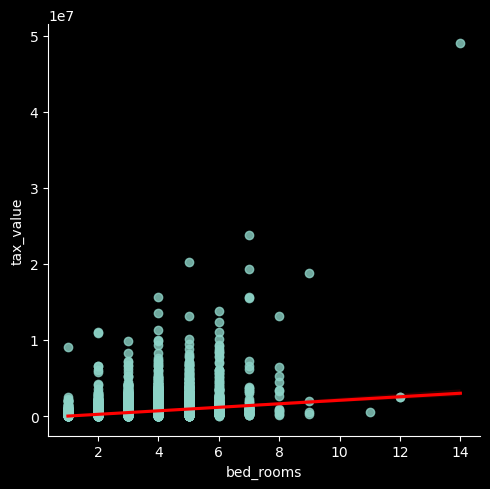

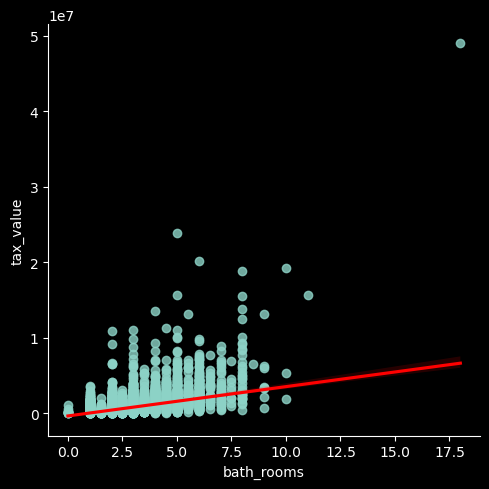

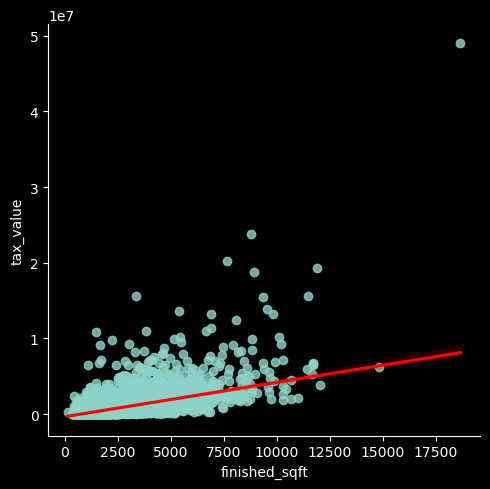

In [178]:
plot_variable_pair(train, cols) # inital look at the data

In [179]:
train.head()

,propertylandusedesc,parcel_id,bed_rooms,bath_rooms,finished_sqft,tax_value,year_built,tax_amount,county,log_error,transaction_date
105774,Single Family Residential,12790893,3,2.0,1618,75126,1951,1224.97,6037,-0.103202,2017-03-01
1245522,Single Family Residential,10835265,5,3.0,1676,429745,1949,5273.91,6037,-0.041547,2017-05-19
1933205,Single Family Residential,17125229,3,2.0,2445,766909,1958,8167.82,6111,0.003930,2017-03-27
1577802,Single Family Residential,14006103,4,3.0,2649,443736,1958,5398.50,6059,0.034483,2017-03-21
1007604,Single Family Residential,12752683,3,3.0,1254,388364,1957,5020.42,6037,-0.113729,2017-08-28


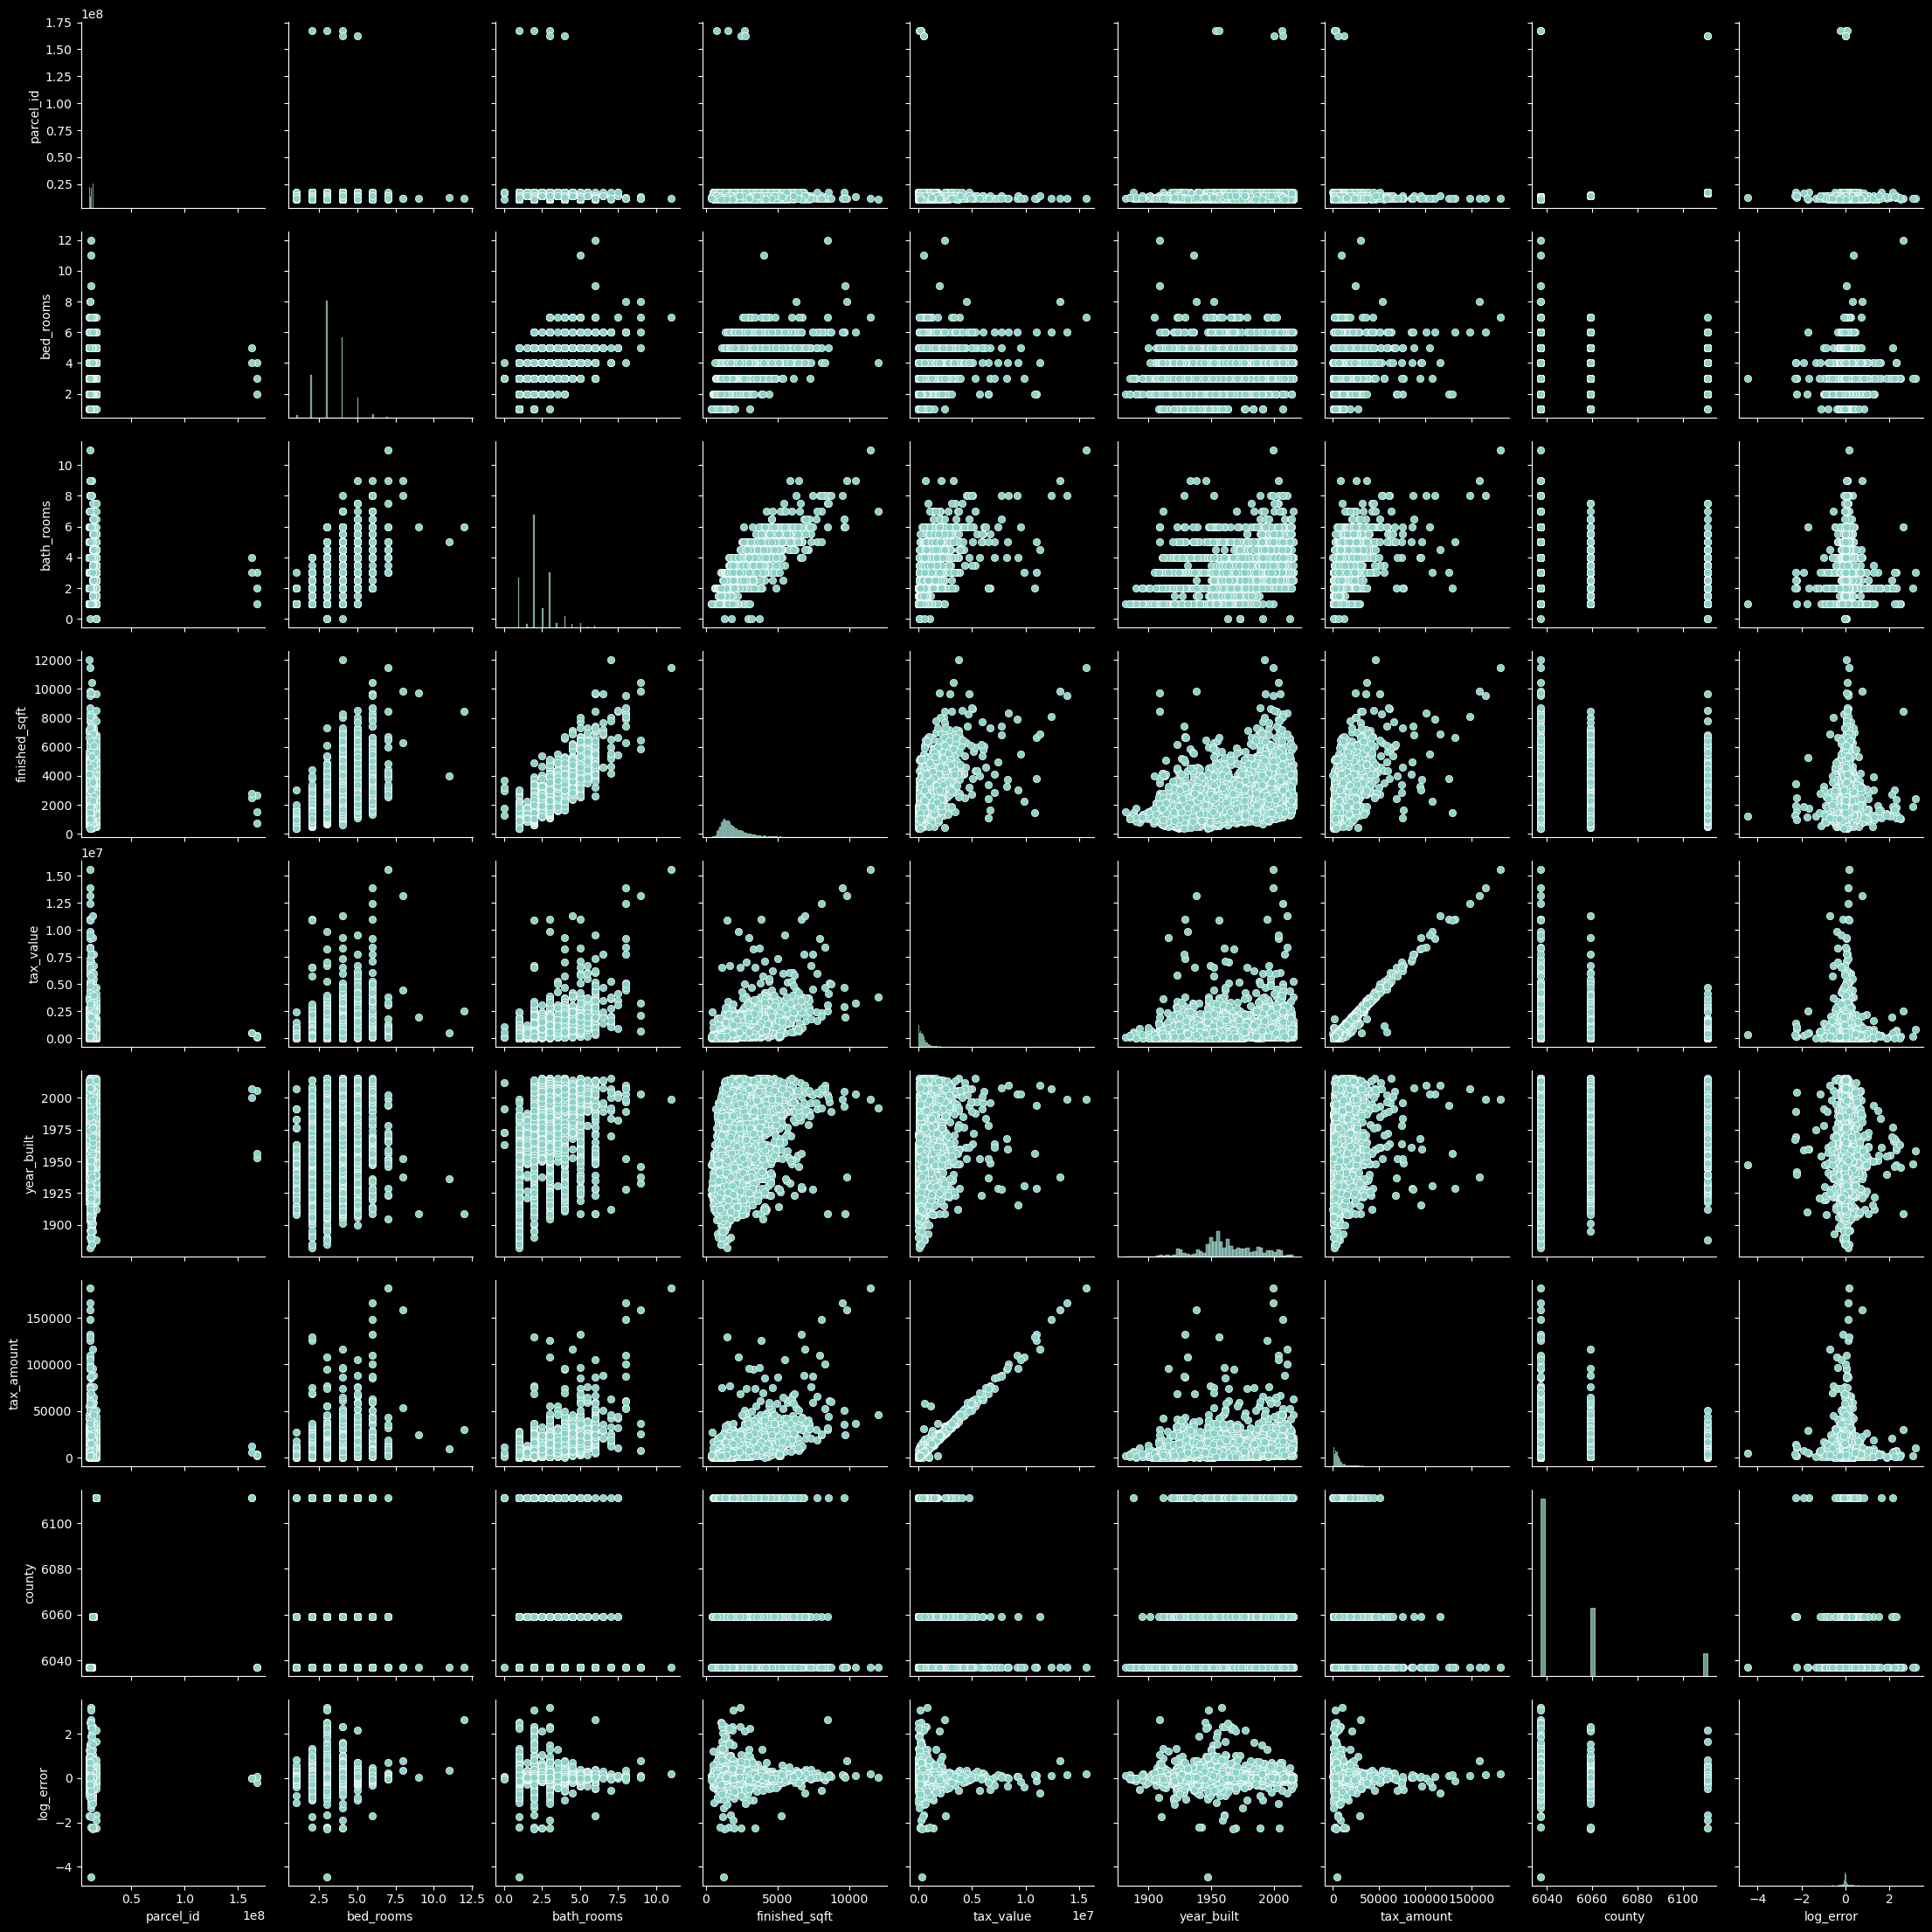

In [180]:
sns.pairplot(data=train.sample(10000)) # inital look at the data 

## Notes form inital look at the data
- possible relationship between bathrooms and finished sqft  

<Axes: xlabel='tax_value', ylabel='Count'>

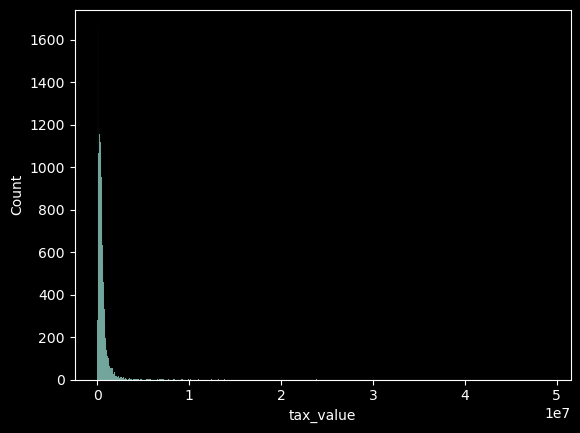

In [181]:
sns.histplot(data=train.tax_value)

In [ ]:
from sklearn.feature_selection import RFE

#make it
rfe = RFE(lr1, n_features_to_select=3)

#fit it
rfe.fit(X_train, y_train)

#use it on train
X_train_rfe = rfe.transform(X_train)

#use it on validate
X_val_rfe = rfe.transform(X_validate)

## Questions 

### Does the time of year impact tax value? 

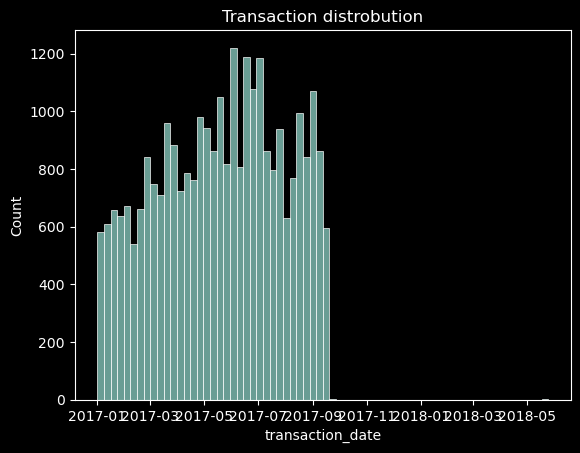

In [182]:
sns.histplot(data=train, x='transaction_date')
plt.title('Transaction distrobution')
plt.show()

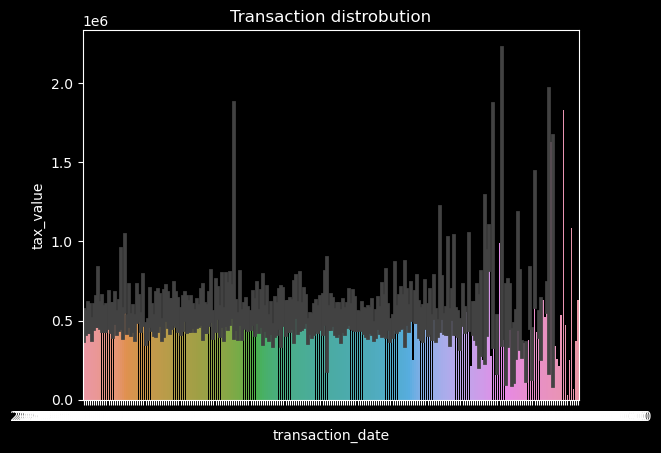

In [183]:
sns.barplot(x='transaction_date', y="tax_value", data=train)
plt.title('Transaction distrobution')
plt.show()

# Question
## Does year built infuance tax value? 

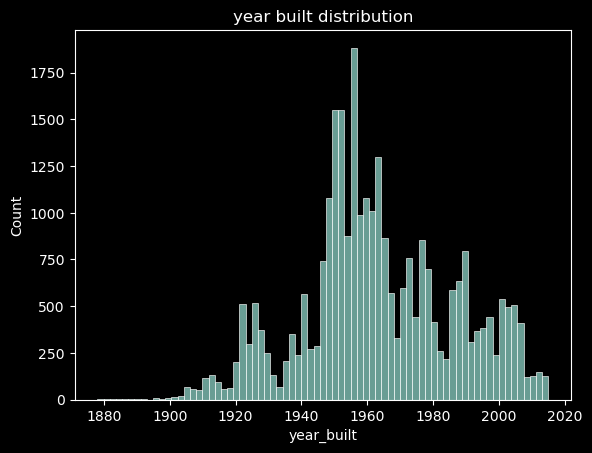

In [184]:
sns.histplot(data=train, x='year_built')
plt.title('year built distribution')
plt.show()

- year built seems to have a normal distrobution 

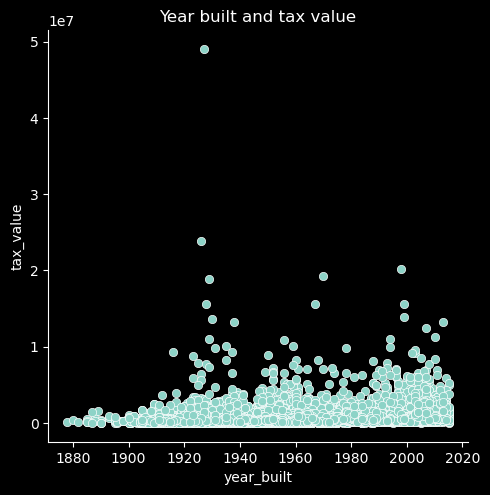

In [185]:
sns.relplot(data=train, x='year_built', y='tax_value')
plt.title('Year built and tax value')
plt.show()

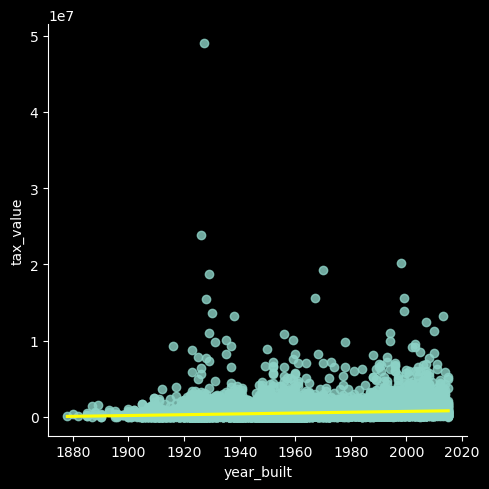

In [186]:
sns.lmplot(x='year_built', y="tax_value", data=train, line_kws={'color': 'yellow'})


- looks their is a positive correlation between year built and tax value 

     Note 
- year built is descrete
- tax value is continues 
- there is some sort of linear relationship between the two 

- we will have to use persons r

# Stats Test 
    
    Null - there is no linear correlation between year built and tax value 
    Alt - there is a linear correlation between year built and tax value 

In [187]:
from scipy import stats # imports 

alpha = 0.05 # set the alpha 


corr, p = stats.pearsonr(train.tax_value, train.year_built) # get the p value 
print(f'corr -> {corr}')
print(f'pvalue -> {p}')

if p < alpha: # compair p value our alpha value 
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

# Will be adding year built to my data dictionary 


corr -> 0.16256195244408272
pvalue -> 1.910051544383663e-172
We reject the null hypothesis


In [188]:
def personsr_test(null, alt, val1, val2): 
    alpha = 0.05

# Question 

### Is tax value infuanced depending on which county it is in? 

In [257]:
train.county.value_counts()

county
6037    19040
6059     7788
6111     2436
Name: count, dtype: int64

In [260]:
train.county[train.county == 6037]

105774     6037
1245522    6037
1007604    6037
27313      6037
394642     6037
           ... 
1341755    6037
1706351    6037
1224440    6037
1469594    6037
654855     6037
Name: county, Length: 19040, dtype: int64

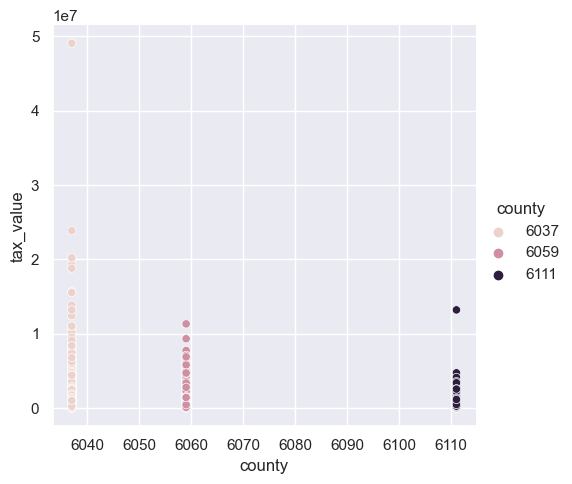

In [268]:
sns.relplot(data=train, y='tax_value', x='county', hue= 'county')


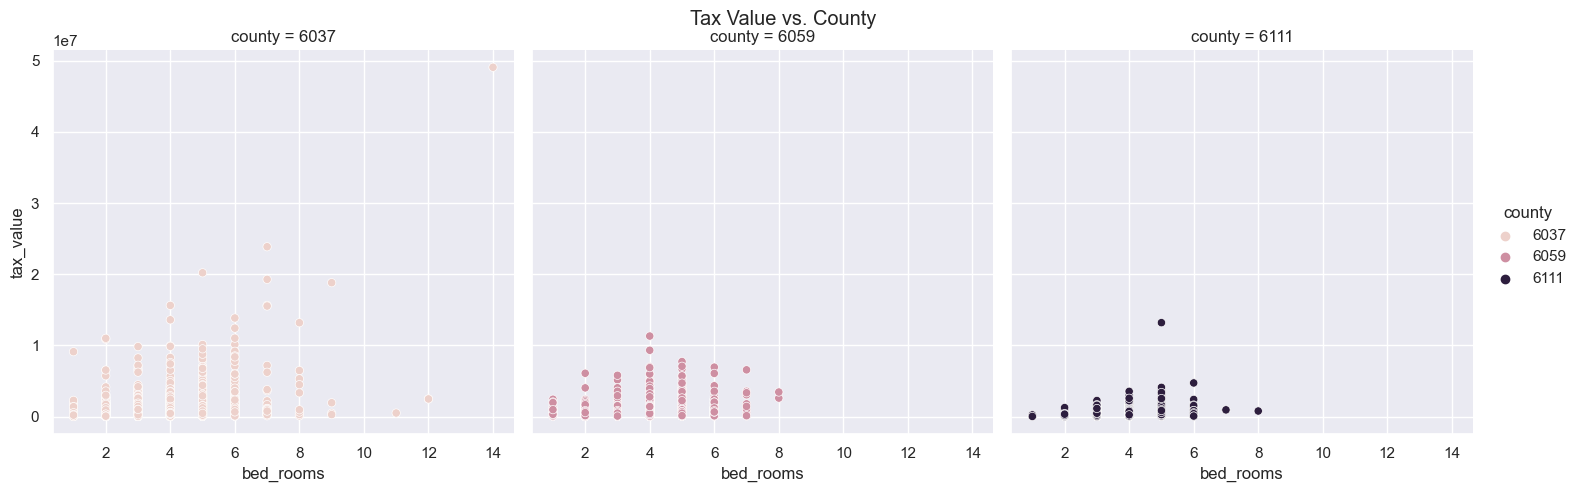

In [279]:
sns.set(style="darkgrid")

# Create a relplot with separate subplots for each county
sns.relplot(data=train, y='tax_value', x='bed_rooms', hue='county', col='county', kind='scatter')

# Set the title and labels for each subplot
plt.subplots_adjust(top=0.9)
plt.suptitle("Tax Value vs. County")

# Show the plot
plt.show()

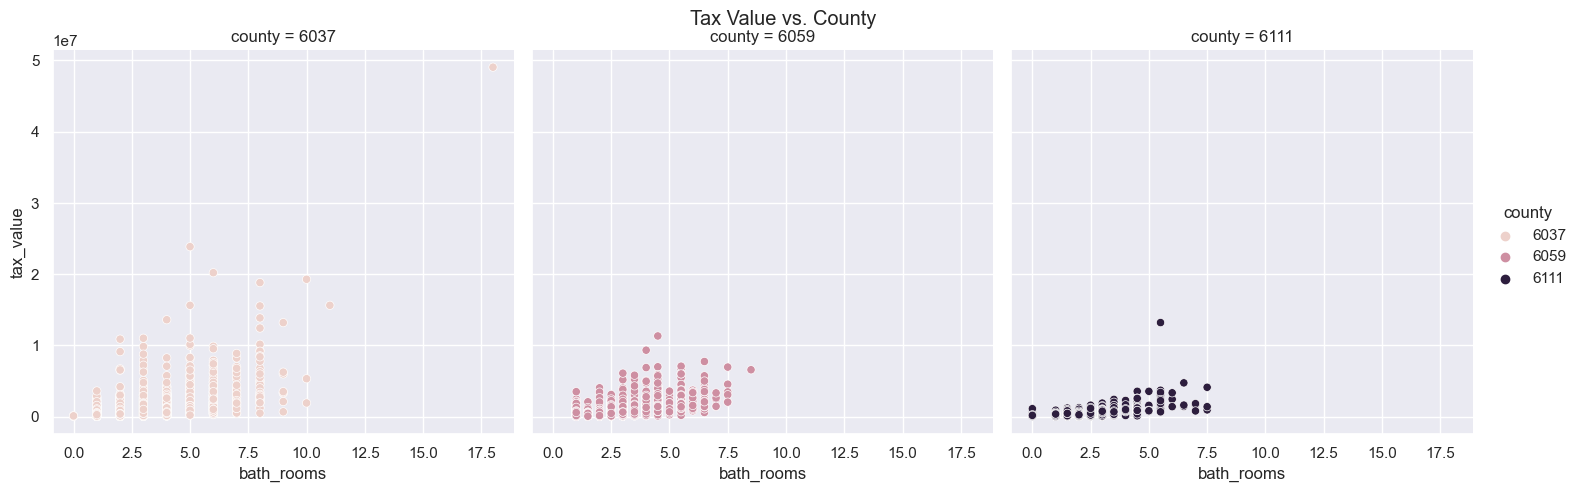

In [285]:
sns.set(style="darkgrid")

# Create a relplot with separate subplots for each county
sns.relplot(data=train, y='tax_value', x='bath_rooms', hue='county', col='county', kind='scatter')

# Set the title and labels for each subplot
plt.subplots_adjust(top=0.9)
plt.suptitle("Tax Value vs. County")

# Show the plot
plt.show()

/var/folders/6d/_03p2v5j0rd067n1f34klb7w0000gn/T/ipykernel_8400/1158879948.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data_subset, y='county', x='tax_value', ax=axes[i], ci=None, orient='h')
/var/folders/6d/_03p2v5j0rd067n1f34klb7w0000gn/T/ipykernel_8400/1158879948.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data_subset, y='county', x='tax_value', ax=axes[i], ci=None, orient='h')
/var/folders/6d/_03p2v5j0rd067n1f34klb7w0000gn/T/ipykernel_8400/1158879948.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data_subset, y='county', x='tax_value', ax=axes[i], ci=None, orient='h')


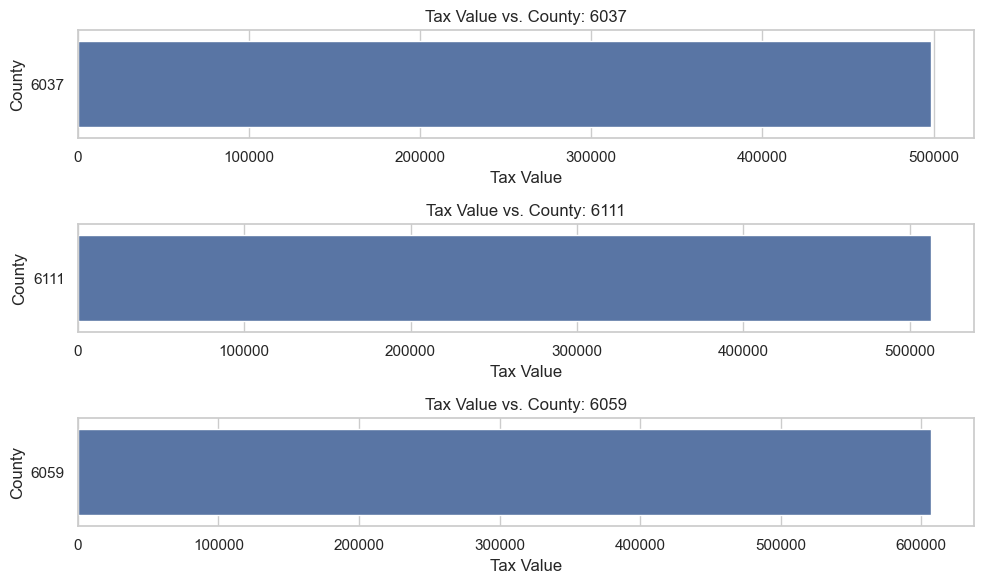

In [287]:
sns.set(style="whitegrid")

# Create subplots for each county
fig, axes = plt.subplots(nrows=len(train['county'].unique()), figsize=(10, 6))

# Loop through unique counties and create a horizontal barplot for each
for i, county in enumerate(train['county'].unique()):
    data_subset = train[train['county'] == county]
    sns.barplot(data=data_subset, y='county', x='tax_value', ax=axes[i], ci=None, orient='h')
    axes[i].set_title(f'Tax Value vs. County: {county}')
    axes[i].set_xlabel('Tax Value')
    axes[i].set_ylabel('County')

# Adjust subplot spacing
plt.tight_layout()

# Show the plot
plt.show()

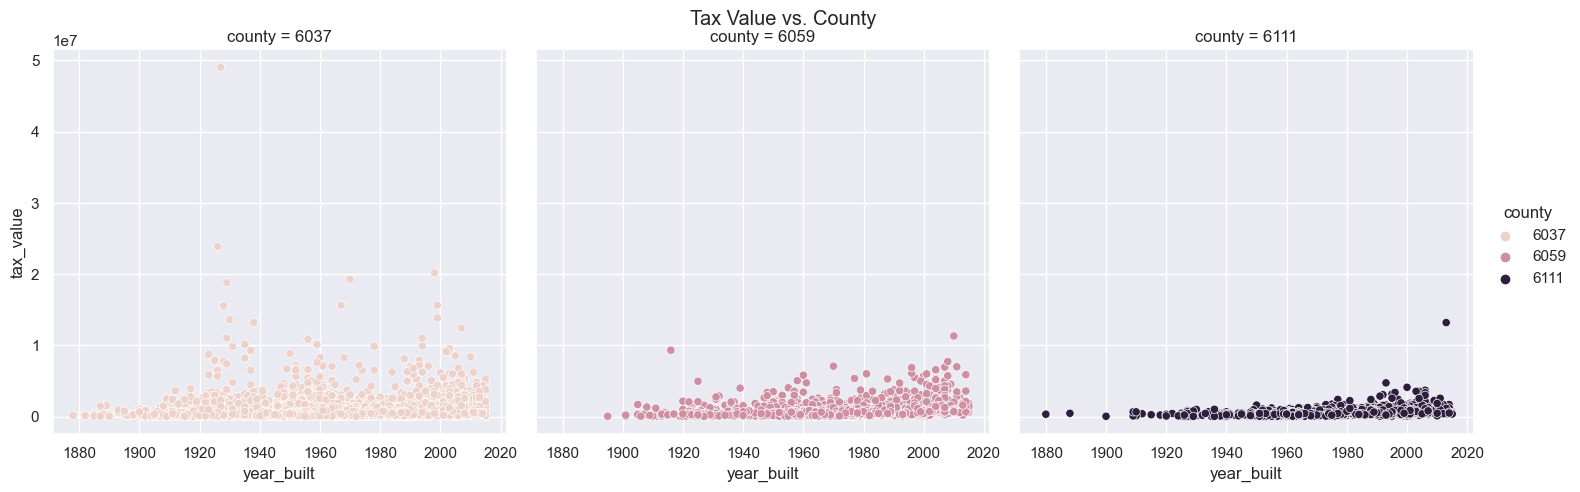

In [282]:
# Assuming your 'train' DataFrame contains the data
sns.set(style="darkgrid")

# Create a relplot with separate subplots for each county
sns.relplot(data=train, y='tax_value', x='year_built', hue='county', col='county', kind='scatter')

# Set the title and labels for each subplot
plt.subplots_adjust(top=0.9)
plt.suptitle("Tax Value vs. County")

# Show the plot
plt.show()

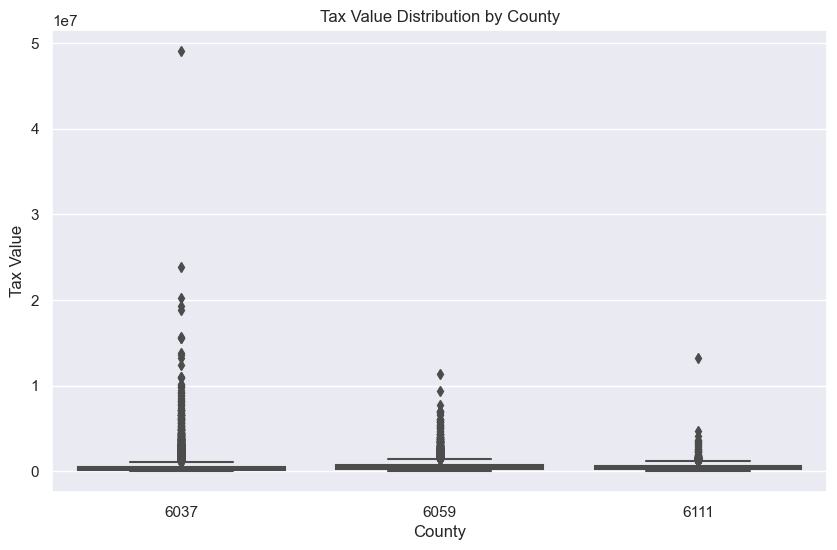

In [289]:
sns.set(style="darkgrid")

plt.figure(figsize=(10, 6))
sns.boxplot(data=train, x='county', y='tax_value')
plt.title("Tax Value Distribution by County")
plt.xlabel("County")
plt.ylabel("Tax Value")

plt.show()

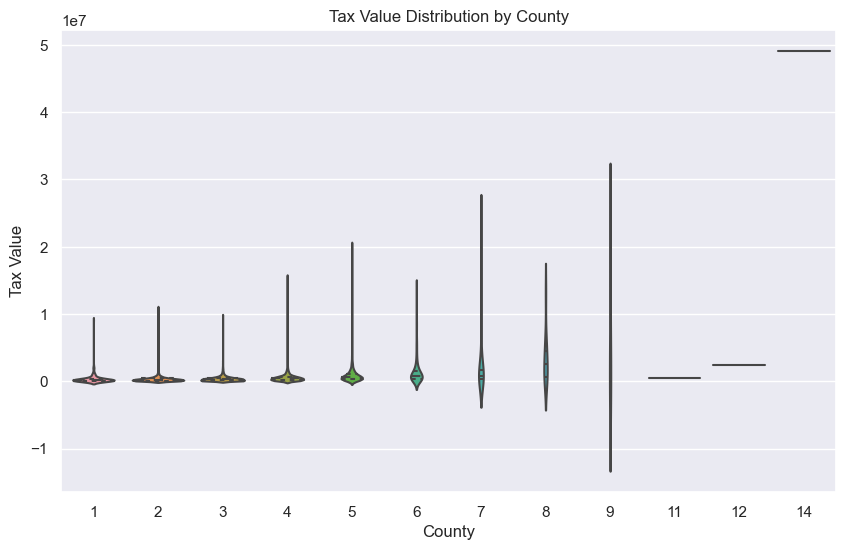

In [291]:
sns.set(style="darkgrid")

plt.figure(figsize=(10, 6))
sns.violinplot(data=train, x='bed_rooms', y='tax_value', inner="quart")
plt.title("Tax Value Distribution by County")
plt.xlabel("County")
plt.ylabel("Tax Value")

plt.show()


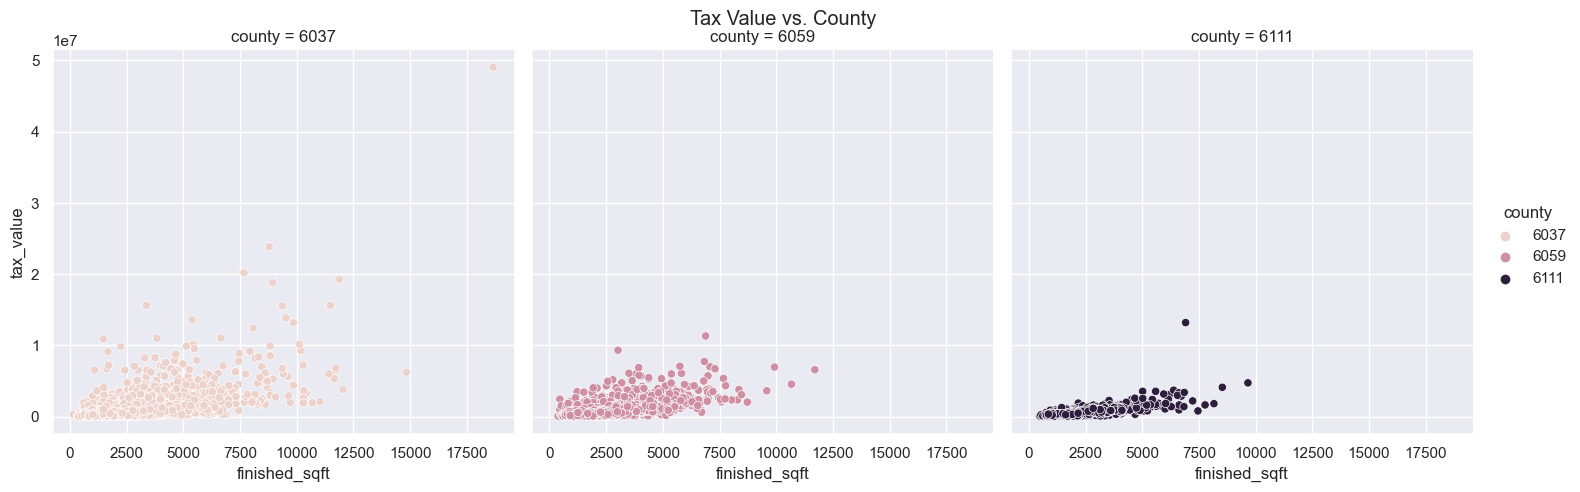

In [283]:
# Assuming your 'train' DataFrame contains the data
sns.set(style="darkgrid")

# Create a relplot with separate subplots for each county
sns.relplot(data=train, y='tax_value', x='finished_sqft', hue='county', col='county', kind='scatter')

# Set the title and labels for each subplot
plt.subplots_adjust(top=0.9)
plt.suptitle("Tax Value vs. County")

# Show the plot
plt.show()

# Question 

## Do number of bedrooms impact tax value? 

In [309]:
train.bed_rooms.mean()

3.3054264625478402

Text(0.5, 1.0, 'Distrobution of bedrooms')

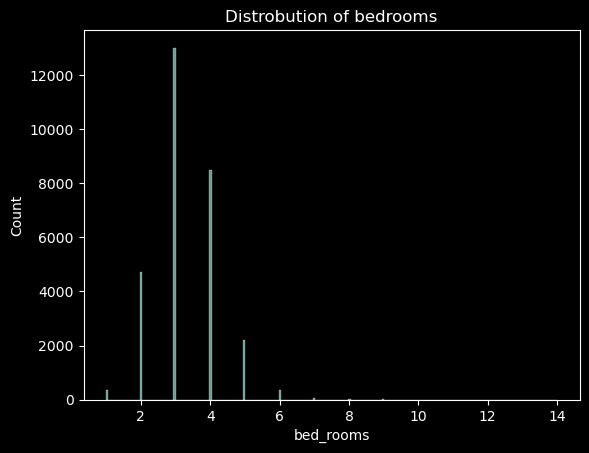

In [189]:
sns.histplot(data=train, x='bed_rooms')
plt.title('Distrobution of bedrooms')

- possibly normal or gamma distrobution 

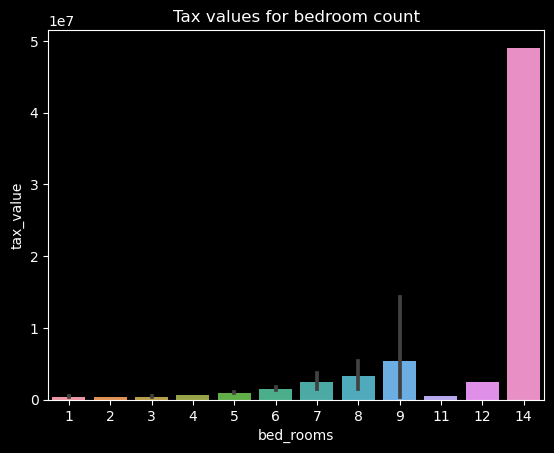

In [190]:
sns.barplot(data=train, x='bed_rooms', y='tax_value')
plt.title('Tax values for bedroom count')
plt.show()

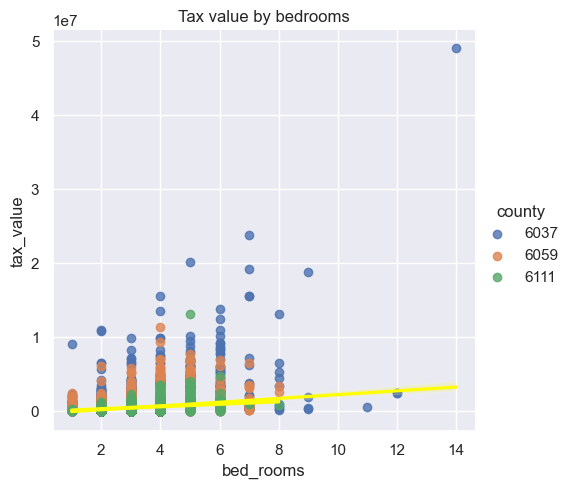

In [280]:
sns.lmplot(x='bed_rooms', y="tax_value", data=train, line_kws={'color': 'yellow'}, hue='county')
plt.title('Tax value by bedrooms')
plt.show()


     Note 
- bedrooms is descrete
- tax value is continues 
- there is some sort of linear relationship between the two 

- we will have to use persons r

# Stats Test 
    
    Null - there is no linear correlation between bedrooms and tax value 
    Alt - there is a linear correlation between bedrooms and tax value 

In [292]:
from scipy import stats # imports 

alpha = 0.05 # set the alpha 


corr, p = stats.pearsonr(train.tax_value, train.bed_rooms) # get the p value 
print(f'corr -> {corr}')
print(f'pvalue -> {p}')

if p < alpha: # compair p value our alpha value 
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

# Will be adding year built to my data dictionary 

corr -> 0.28215954565588985
pvalue -> 0.0
We reject the null hypothesis


# Question 

## Do number of bedrooms impact tax value? 

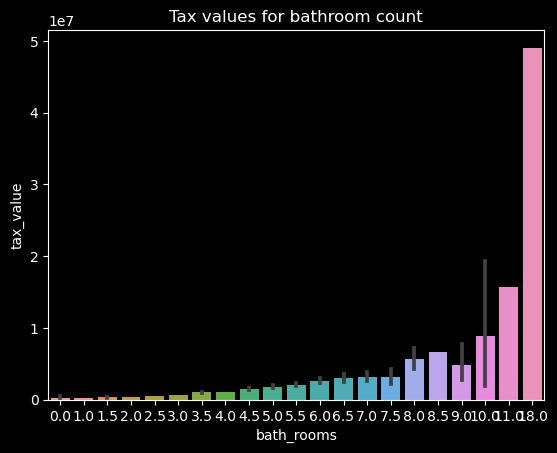

In [192]:
sns.barplot(data=train, x='bath_rooms', y='tax_value')
plt.title('Tax values for bathroom count')
plt.show()

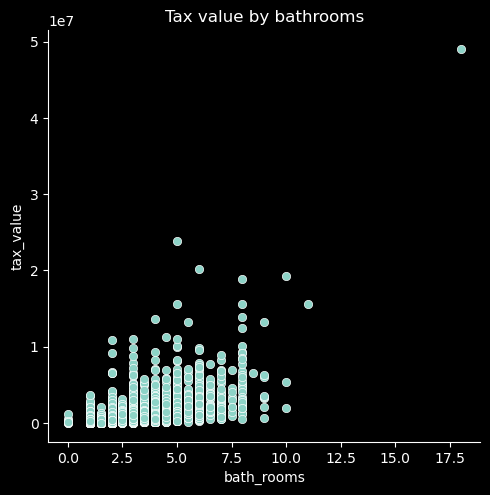

In [193]:
sns.relplot(data=train, y='tax_value', x='bath_rooms')
plt.title('Tax value by bathrooms')
plt.show()

# Stats Test 
    
    Null - there is no linear correlation between bathrooms and tax value 
    Alt - there is a linear correlation between bathrooms and tax value 

In [293]:
from scipy import stats # imports 

alpha = 0.05 # set the alpha 


corr, p = stats.pearsonr(train.tax_value, train.bath_rooms) # get the p value 
print(f'corr -> {corr}')
print(f'pvalue -> {p}')

if p < alpha: # compair p value our alpha value 
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

# Will be adding year built to my data dictionary 

corr -> 0.5156896400601059
pvalue -> 0.0
We reject the null hypothesis


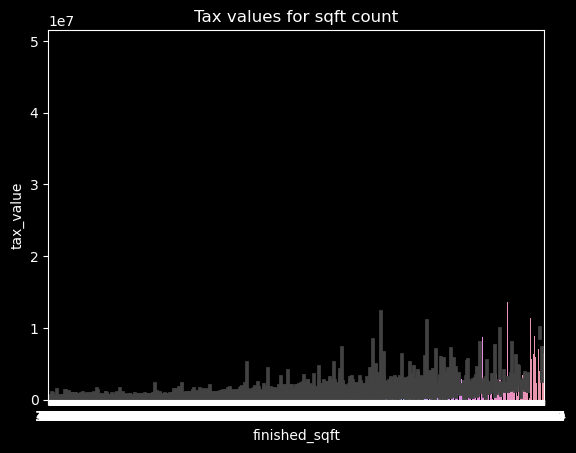

In [194]:
sns.barplot(data=train, x='finished_sqft', y='tax_value')
plt.title('Tax values for sqft count')
plt.show()

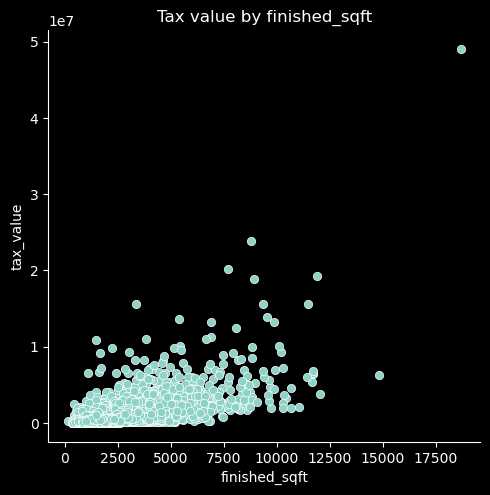

In [195]:
sns.relplot(data=train, y='tax_value', x='finished_sqft')
plt.title('Tax value by finished_sqft')
plt.show()

# Stats Test 
    
    Null - there is no linear correlation between finished sqft and tax value 
    Alt - there is a linear correlation between finished sqft and tax value 

In [294]:
from scipy import stats # imports 

alpha = 0.05 # set the alpha 


corr, p = stats.pearsonr(train.tax_value, train.finished_sqft) # get the p value 
print(f'corr -> {corr}')
print(f'pvalue -> {p}')

if p < alpha: # compair p value our alpha value 
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

# Will be adding year built to my data dictionary 

corr -> 0.592300816684442
pvalue -> 0.0
We reject the null hypothesis


## Question 
### What is parcel_id? 

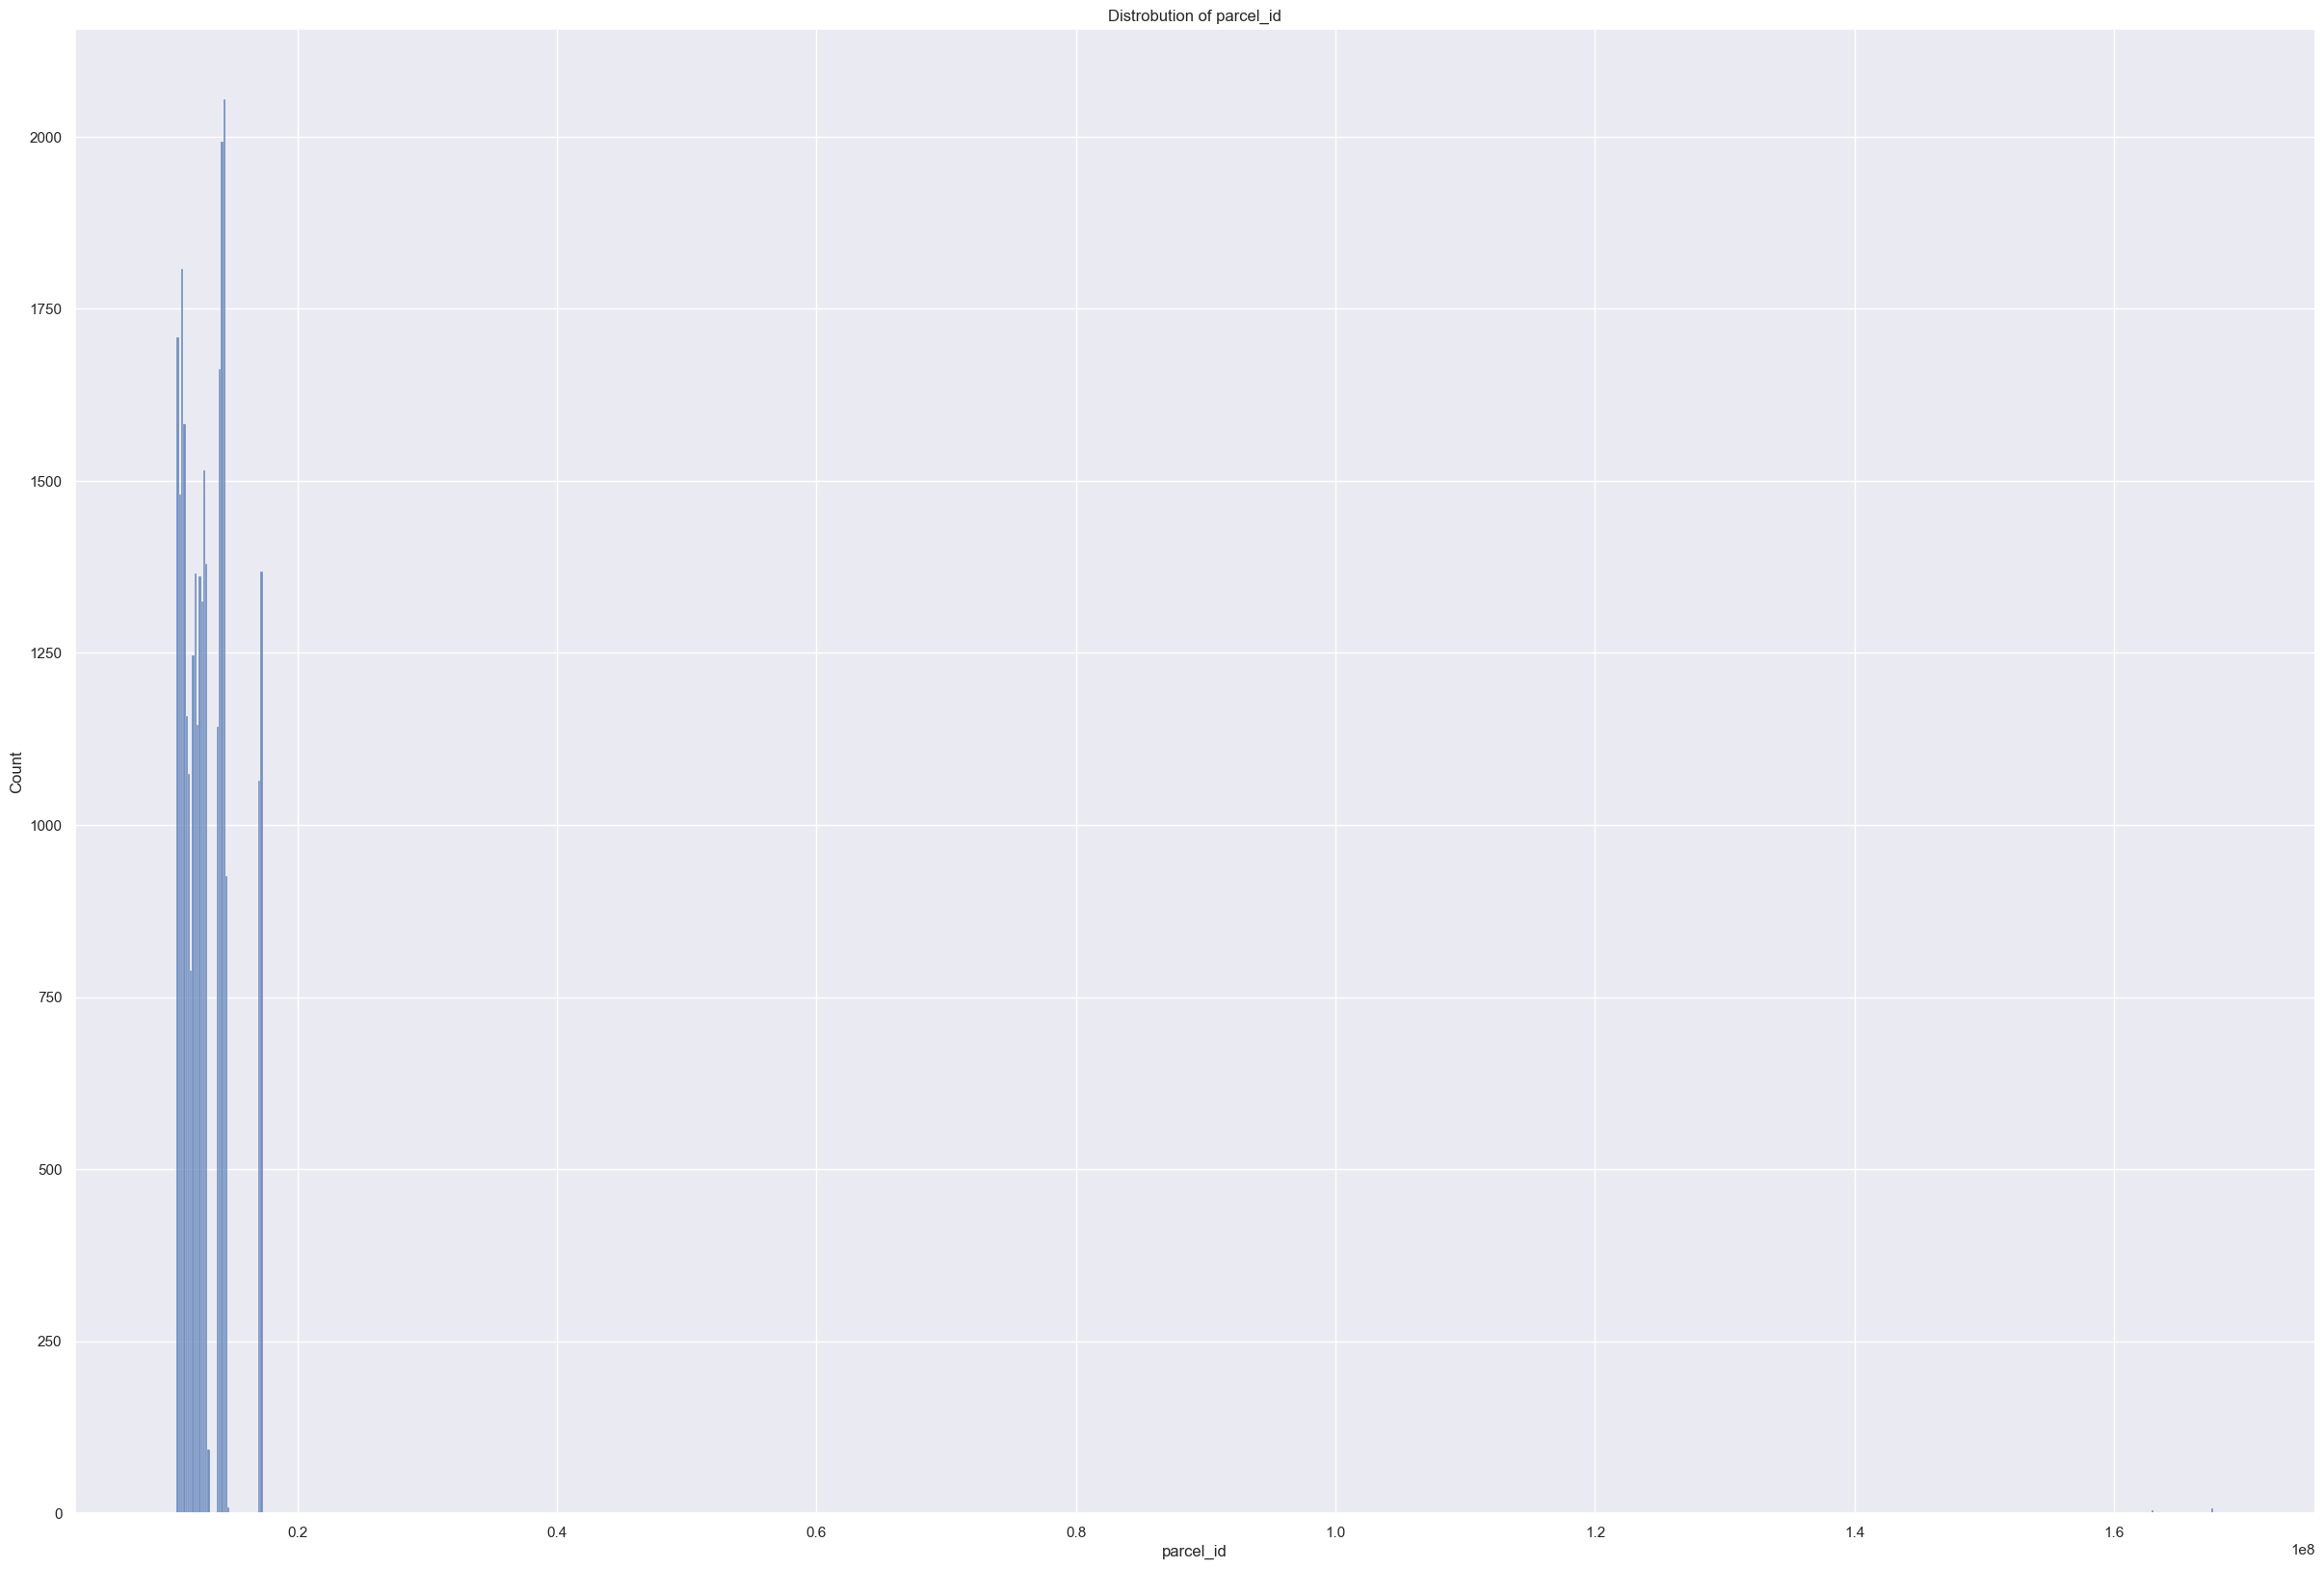

In [302]:
sns.histplot(data=train, x='parcel_id')
plt.title('Distrobution of parcel_id')
plt.show()

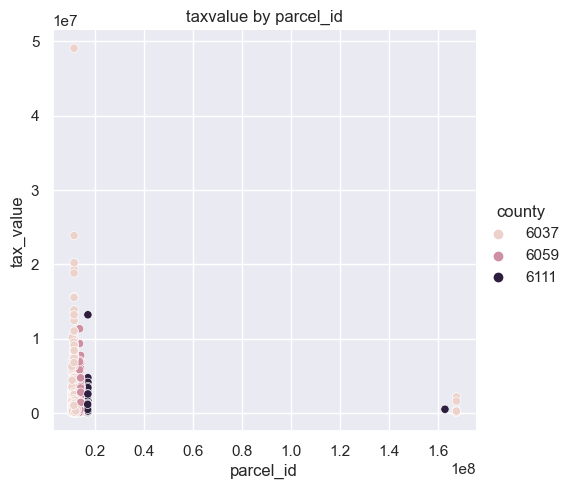

In [304]:
sns.relplot(data=train, y='tax_value', x='parcel_id', hue='county')
plt.title('taxvalue by parcel_id')
plt.show()

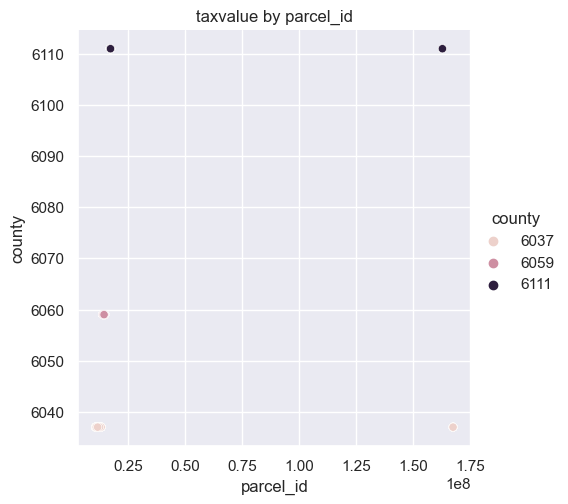

In [305]:
sns.relplot(data=train, y='county', x='parcel_id', hue='county')
plt.title('taxvalue by parcel_id')
plt.show()

# Question
### What is log_error? 

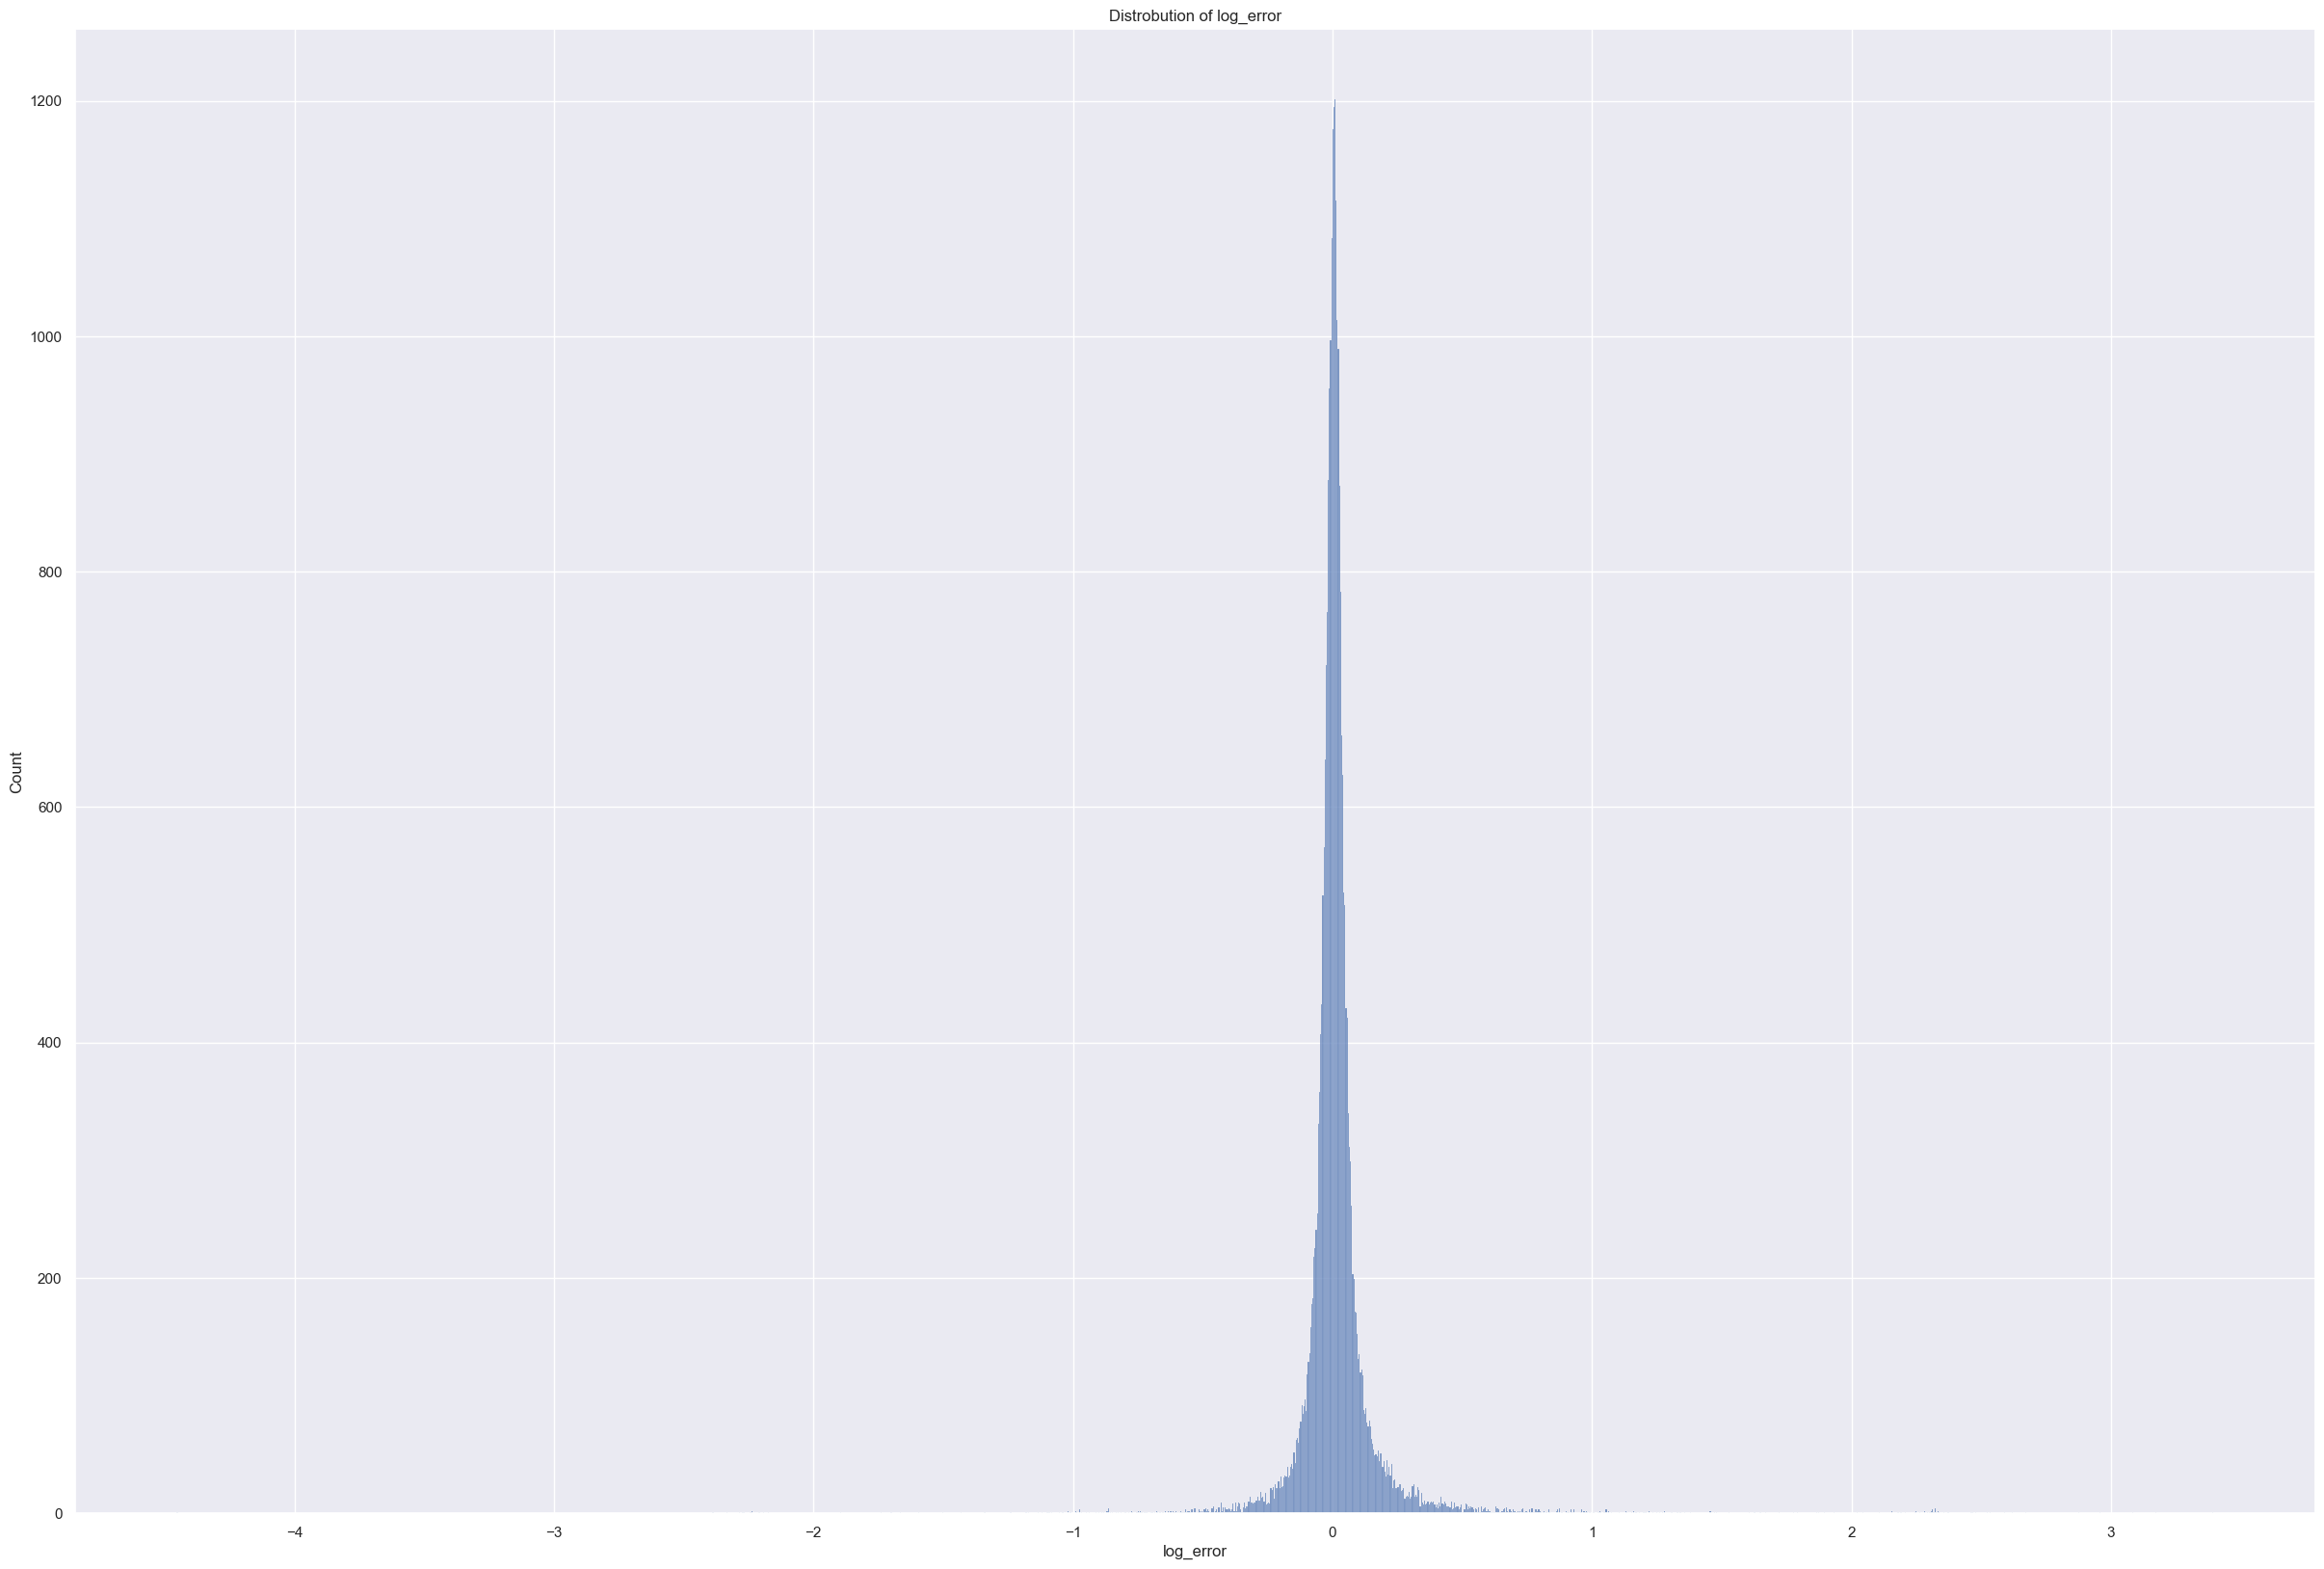

In [306]:
sns.histplot(data=train, x='log_error')
plt.title('Distrobution of log_error')
plt.show()

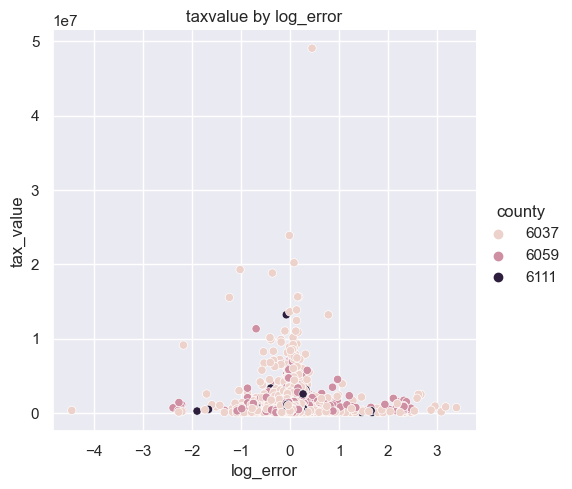

In [307]:
sns.relplot(data=train, y='tax_value', x='log_error', hue='county')
plt.title('taxvalue by log_error')
plt.show()

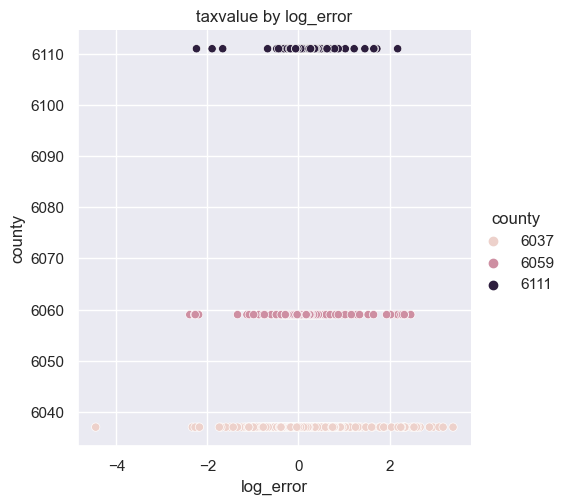

In [308]:
sns.relplot(data=train, y='county', x='log_error', hue='county')
plt.title('taxvalue by log_error')
plt.show()

## Question 
### What is the average sqft for a 3 bedroom single family propery by county? 

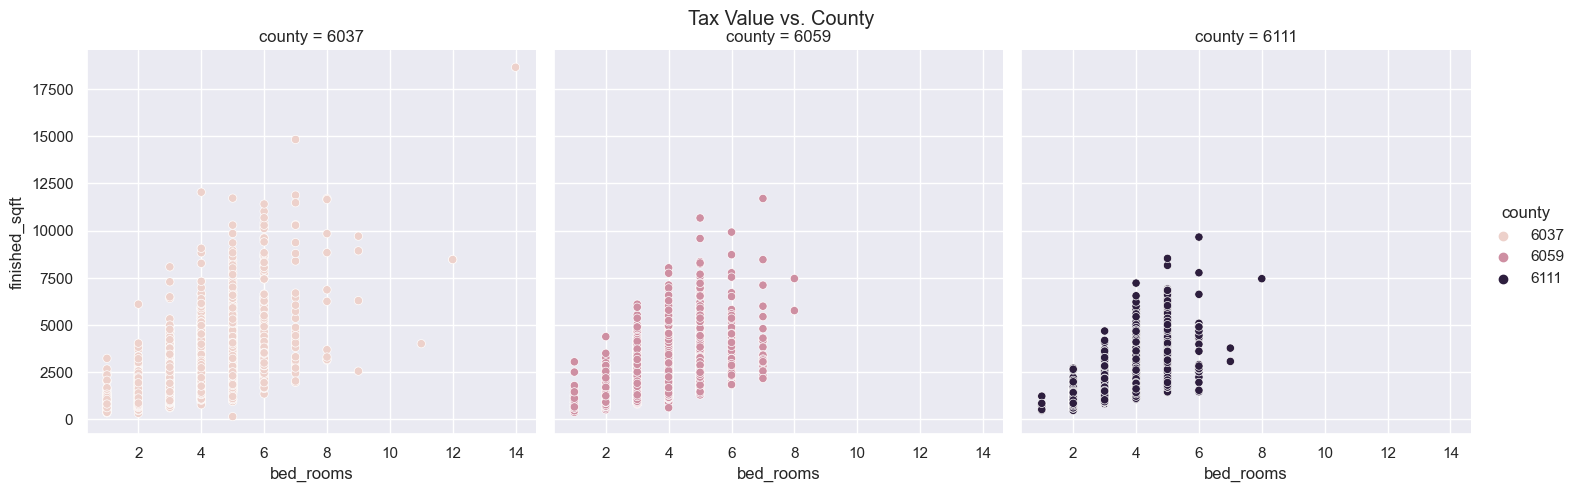

In [300]:
# Assuming your 'train' DataFrame contains the data
sns.set(style="darkgrid")

# Create a relplot with separate subplots for each county
sns.relplot(data=train, y='finished_sqft', x='bed_rooms', hue='county', col='county', kind='scatter')

# Set the title and labels for each subplot
plt.subplots_adjust(top=0.9)
plt.suptitle("Tax Value vs. County")

# Show the plot
plt.show()

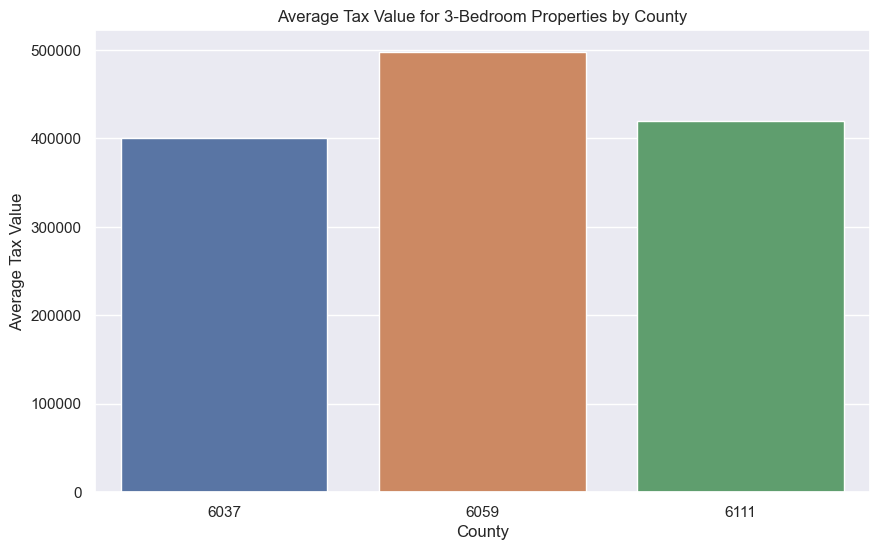

In [296]:
sns.set(style="darkgrid")

# Filter the data for 3-bedroom properties
three_bedroom_data = train[train['bed_rooms'] == 3]

# Calculate the average tax value per county for 3-bedroom properties
average_tax_per_county = three_bedroom_data.groupby('county')['tax_value'].mean().reset_index()

# Create a barplot to visualize the average tax value for 3-bedroom properties per county
plt.figure(figsize=(10, 6))
sns.barplot(data=average_tax_per_county, x='county', y='tax_value')
plt.title("Average Tax Value for 3-Bedroom Properties by County")
plt.xlabel("County")
plt.ylabel("Average Tax Value")

plt.show()

/Users/ramirolopez/anaconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


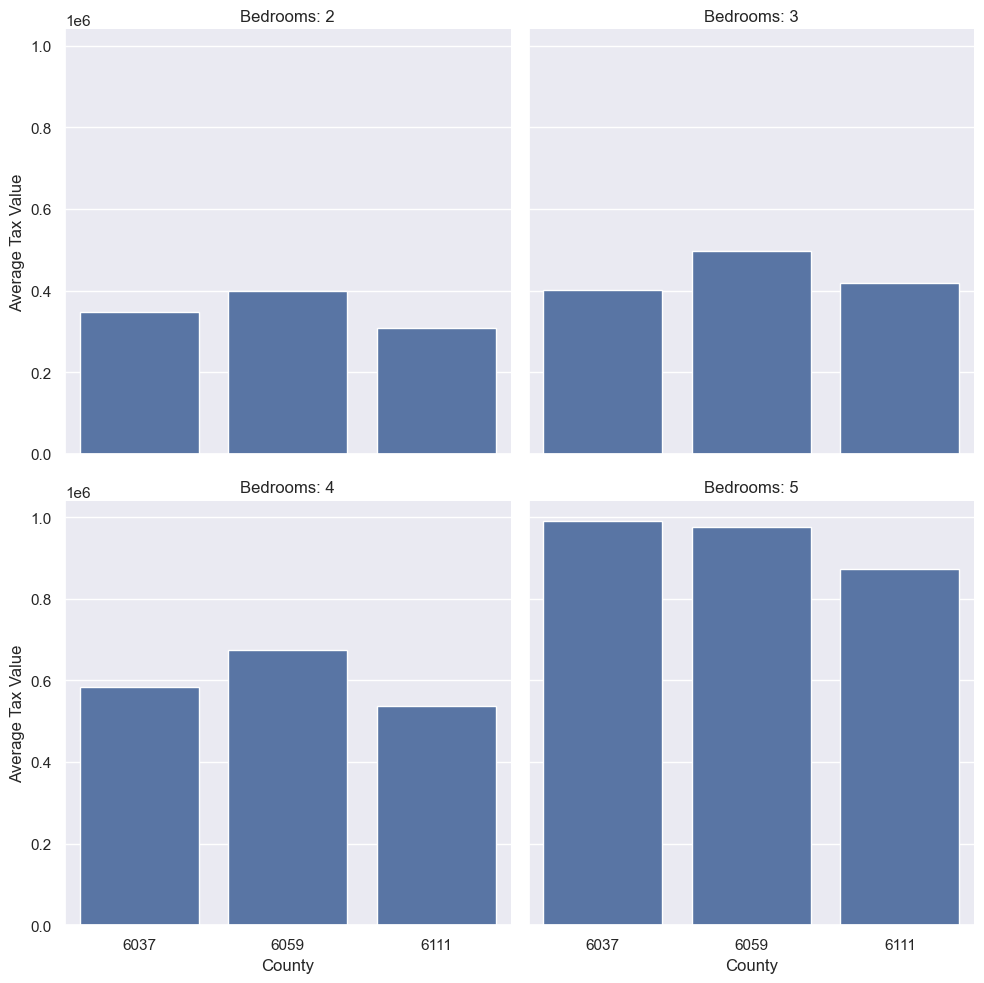

In [298]:
sns.set(style="darkgrid")

# Filter the data for properties with 2 to 5 bedrooms
filtered_data = train[(train['bed_rooms'] >= 2) & (train['bed_rooms'] <= 5)]

# Calculate the average tax value per county for properties with 2 to 5 bedrooms
average_tax_per_county = filtered_data.groupby(['bed_rooms', 'county'])['tax_value'].mean().reset_index()

# Create a FacetGrid to display subplots for each bedroom count
g = sns.FacetGrid(average_tax_per_county, col='bed_rooms', col_wrap=2, height=5)
g.map(sns.barplot, 'county', 'tax_value')
g.set_axis_labels("County", "Average Tax Value")
g.set_titles("Bedrooms: {col_name}")

# Adjust subplot spacing
plt.tight_layout()

# Show the plot
plt.show()

In [197]:
train.head(1)

,propertylandusedesc,parcel_id,bed_rooms,bath_rooms,finished_sqft,tax_value,year_built,tax_amount,county,log_error,transaction_date
105774,Single Family Residential,12790893,3,2.0,1618,75126,1951,1224.97,6037,-0.103202,2017-03-01


# Data Dictionary

|Feature|Discription|
| - | - |
|bed_rooms|Number of bed rooms|
|bath_rooms|Number of bathrooms|
Finished_SQFT| usable space| 


# scale data 

In [198]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer # now that our data is split we can scale it

mms = MinMaxScaler() # creeating the scaler 
ss = StandardScaler() # creating the scaler
rs = RobustScaler() # creating the scaler 
qt = QuantileTransformer() # creating the scaler

In [199]:
def scale_data(train, validate, test, columns_to_scale=['bed_rooms', 'bath_rooms', 'tax_value', 'finished_sqft'], return_scaler=False):
    '''
    Scales the 3 data splits. 
    Takes in train, validate, and test data splits and returns their scaled counterparts.
    If return_scalar is True, the scaler object will be returned as well
    '''
    # make copies of our original data so we dont gronk up anything
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    #     make the thing
    scaler = StandardScaler()
    #     fit the thing
    scaler.fit(train[columns_to_scale])
    # applying the scaler:
    train_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(train[columns_to_scale]),
                                                  columns=train[columns_to_scale].columns.values).set_index([train.index.values])
                                                  
    validate_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(validate[columns_to_scale]),
                                                  columns=validate[columns_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(test[columns_to_scale]),
                                                 columns=test[columns_to_scale].columns.values).set_index([test.index.values])
    
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    return train_scaled, validate_scaled, test_scaled

In [200]:
def scale_train_data(train, 
               validate, 
               test, 
               cols_to_scale,
               scale,
               return_scaler=False):
    '''
    Scales the 3 data splits. 
    Takes in train, validate, and test data splits and returns their scaled counterparts.
    If return_scalar is True, the scaler object will be returned as well
    '''
    # make copies of our original data so we dont gronk up anything
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    #     make the thing
    scaler = scale
    #     fit the thing
    scaler.fit(train[cols_to_scale])
    # applying the scaler:
    train_scaled[cols_to_scale] = pd.DataFrame(scaler.transform(train[cols_to_scale]),
                                                  columns=train[cols_to_scale].columns.values).set_index([train.index.values])
                                                  
    validate_scaled[cols_to_scale] = pd.DataFrame(scaler.transform(validate[cols_to_scale]),
                                                  columns=validate[cols_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[cols_to_scale] = pd.DataFrame(scaler.transform(test[cols_to_scale]),
                                                 columns=test[cols_to_scale].columns.values).set_index([test.index.values])
    
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

## Min Max Scaler

In [201]:
scaler, train_scaled_mm, validate_scaled_mm, test_scaled_mm = scale_data(train, validate, test, return_scaler=True)

In [202]:
train_scaled_mm.head(3)

,propertylandusedesc,parcel_id,bed_rooms,bath_rooms,finished_sqft,tax_value,year_built,tax_amount,county,log_error,transaction_date
105774,Single Family Residential,12790893,-0.325587,-0.292455,-0.302814,-0.591070,1951,1224.97,6037,-0.103202,2017-03-01
1245522,Single Family Residential,10835265,1.806429,0.688677,-0.244900,-0.128981,1949,5273.91,6037,-0.041547,2017-05-19
1933205,Single Family Residential,17125229,-0.325587,-0.292455,0.522958,0.310363,1958,8167.82,6111,0.003930,2017-03-27


# StandardScaler

In [203]:
scaler, train_scaled_ss, validate_scaled_ss, test_scaled_ss = scale_data(train, validate, test, return_scaler=True)

In [204]:
train_scaled_ss.head()

,propertylandusedesc,parcel_id,bed_rooms,bath_rooms,finished_sqft,tax_value,year_built,tax_amount,county,log_error,transaction_date
105774,Single Family Residential,12790893,-0.325587,-0.292455,-0.302814,-0.591070,1951,1224.97,6037,-0.103202,2017-03-01
1245522,Single Family Residential,10835265,1.806429,0.688677,-0.244900,-0.128981,1949,5273.91,6037,-0.041547,2017-05-19
1933205,Single Family Residential,17125229,-0.325587,-0.292455,0.522958,0.310363,1958,8167.82,6111,0.003930,2017-03-27
1577802,Single Family Residential,14006103,0.740421,0.688677,0.726655,-0.110750,1958,5398.50,6059,0.034483,2017-03-21
1007604,Single Family Residential,12752683,-0.325587,0.688677,-0.666274,-0.182903,1957,5020.42,6037,-0.113729,2017-08-28


# RobustScaler

In [205]:
cols = ['bed_rooms', 'bath_rooms', 'finished_sqft']

train_scaled_rs, validate_scaled_rs, test_scaled_rs = scale_train_data(train, validate, test, scale=RobustScaler(),cols_to_scale= cols)

In [206]:
train_scaled_rs.bed_rooms.max()

11.0

In [207]:
train_scaled_rs.head()

,propertylandusedesc,parcel_id,bed_rooms,bath_rooms,finished_sqft,tax_value,year_built,tax_amount,county,log_error,transaction_date
105774,Single Family Residential,12790893,0.0,0.0,-0.039537,75126,1951,1224.97,6037,-0.103202,2017-03-01
1245522,Single Family Residential,10835265,2.0,1.0,0.016393,429745,1949,5273.91,6037,-0.041547,2017-05-19
1933205,Single Family Residential,17125229,0.0,0.0,0.757956,766909,1958,8167.82,6111,0.003930,2017-03-27
1577802,Single Family Residential,14006103,1.0,1.0,0.954677,443736,1958,5398.50,6059,0.034483,2017-03-21
1007604,Single Family Residential,12752683,0.0,1.0,-0.390550,388364,1957,5020.42,6037,-0.113729,2017-08-28


# split x and y

In [208]:
X_train = train_scaled_ss.drop(columns=['tax_value', 'propertylandusedesc', 'parcel_id', 'year_built', 'tax_amount', 'county', 'log_error', 'transaction_date'])

X_train.head(3)

,bed_rooms,bath_rooms,finished_sqft
105774,-0.325587,-0.292455,-0.302814
1245522,1.806429,0.688677,-0.244900
1933205,-0.325587,-0.292455,0.522958


In [209]:
X_validate = validate_scaled_ss.drop(columns=['tax_value', 'propertylandusedesc', 'parcel_id', 'year_built', 'tax_amount', 'county', 'log_error', 'transaction_date'])
X_test = test_scaled_ss.drop(columns=['tax_value', 'propertylandusedesc', 'parcel_id', 'year_built', 'tax_amount', 'county', 'log_error', 'transaction_date'])

In [ ]:
def split_X(df):
    X_train = df.drop(columns=['tax_value', 'propertylandusedesc', 'parcel_id', 'year_built', 'tax_amount', 'county', 'log_error', 'transaction_date'])
    X_validate = df.drop(columns=['tax_value', 'propertylandusedesc', 'parcel_id', 'year_built', 'tax_amount', 'county', 'log_error', 'transaction_date'])
    X_test = df.drop(columns=['tax_value', 'propertylandusedesc', 'parcel_id', 'year_built', 'tax_amount', 'county', 'log_error', 'transaction_date'])
    return X_train, X_validate, X_test

In [210]:
y_train = train.tax_value
y_train.head()

105774      75126
1245522    429745
1933205    766909
1577802    443736
1007604    388364
Name: tax_value, dtype: int64

In [211]:
y_validate = validate.tax_value
y_test = test.tax_value

In [ ]:
def split_y(df):
    y_train = train.tax_value
    y_validate = validate.tax_value
    y_test = test.tax_value
    return y_train, y_validate, y_test

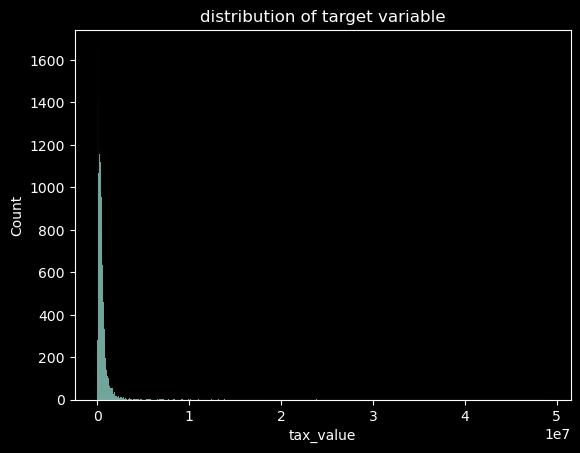

In [212]:
sns.histplot(y_train)
plt.title('distribution of target variable')
plt.show()

# baseline

In [213]:
baseline = y_train.mean()
baseline

528728.4095133953

MMS
SS - 2.607296016323415e-17
RS

In [214]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def metrics_reg(y, yhat):
    """
    send in y_true, y_pred & returns RMSE, R2
    """
    rmse = mean_squared_error(y, yhat, squared=False)
    r2 = r2_score(y, yhat)
    return rmse, r2

In [215]:
#make an array to send into my mean_square_error function
baseline_array = np.repeat(baseline, len(train))
baseline_array[:5]

array([528728.4095134, 528728.4095134, 528728.4095134, 528728.4095134,
       528728.4095134])

In [216]:
rmse, r2 = metrics_reg(y_train, baseline_array)
rmse, r2

(767425.6531984037, 0.0)

SS - (1.0, 0.0)

In [217]:
metrics_df = pd.DataFrame(data=[
    {
        'model':'baseline',
        'rmse':rmse,
        'r2':r2
    }
    
])
metrics_df

,model,rmse,r2
0,baseline,767425.653198,0.0


In [ ]:
def 

# Ordinary Least Squares (OLS)

In [218]:
#import
from sklearn.linear_model import LinearRegression

### simple linear regression + RFE

send in only one feature

In [219]:
from sklearn.feature_selection import RFE

In [220]:
#intial ML model
lr1 = LinearRegression()

#make it
rfe = RFE(lr1, n_features_to_select=1)

#fit it
rfe.fit(X_train, y_train)

#use it on train
X_train_rfe = rfe.transform(X_train)

#use it on validate
X_val_rfe = rfe.transform(X_validate)

In [221]:
print('selected top feature:', rfe.get_feature_names_out())

selected top feature: ['finished_sqft']


#### build model from top feature

In [222]:
#fit the thing
lr1.fit(X_train_rfe, y_train)

#use the thing (make predictions)
pred_lr1 = lr1.predict(X_train_rfe)
pred_val_lr1 = lr1.predict(X_val_rfe)

In [223]:
pred_lr1[:10]

array([391085.09034704, 417409.66578691, 766437.22636028, 859027.11239015,
       225875.68586237, 244938.30945676, 732850.69907494, 293502.61242341,
       699264.17178959,  57035.30545497])

### Evaluate

In [224]:
#train
metrics_reg(y_train, pred_lr1)

(618327.8276141991, 0.35082025744505474)

In [225]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_lr1)
rmse, r2

(589000.2963530571, 0.3874126539206004)

In [226]:
#add to my metrics df
metrics_df.loc[1] = ['ols_1', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,767425.653198,0.000000
1,ols_1,589000.296353,0.387413


## Delete later

## examin model 

In [227]:
lr1.intercept_

528728.4095133953

In [228]:
lr1.coef_

array([454546.841134])

In [229]:
print(f'tax_value = {lr1.intercept_:.3} + {lr1.coef_[0]:.2}*fininished_sqft')

tax_value = 5.29e+05 + 4.5e+05*fininished_sqft


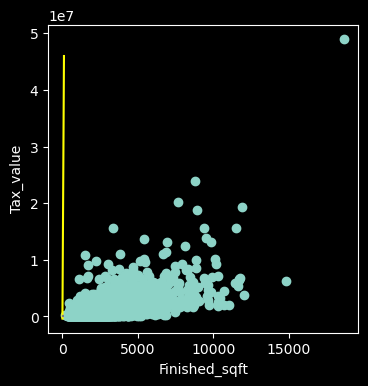

In [230]:
plt.figure(figsize=(4, 4))

plt.scatter(train.finished_sqft, train.tax_value)

#build prediction line from intercept and slope
x_val = np.array([-2, 100]).reshape(-1, 1)
plt.plot(x_val, lr1.intercept_ + x_val*lr1.coef_[0], c='yellow')

#intercept line
plt.hlines(22, -5, 100, ls=':', color='red')  

#(0,0) axis
plt.hlines(0, -5, 100, ls='--', color='grey')
plt.vlines(0, -10, 100, ls='--', color='grey')
 
plt.xlabel('Finished_sqft')
plt.ylabel('Tax_value')
plt.show()

### Multiple Regression

In [231]:
#make it
lr2 = LinearRegression()

#fit it on our RFE features
lr2.fit(X_train, y_train)

#use it (make predictions)
pred_lr2 = lr2.predict(X_train)

#use it on validate
pred_val_lr2 = lr2.predict(X_validate)

In [232]:
pred_lr2[:10]

array([406437.27350727, 222701.26887015, 796363.04040725, 826694.95170829,
       314190.18712305, 399845.86791075, 840849.29429024, 384442.83436379,
       515499.21475272, 125270.40695739])

### Evaluate

In [233]:
#train 
metrics_reg(y_train, pred_lr2)

(609745.6496260399, 0.36871598025092633)

In [234]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_lr2)
rmse, r2

(577148.081488508, 0.4118183008133717)

In [235]:
#add to my metrics df
metrics_df.loc[2] = ['ols', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,767425.653198,0.000000
1,ols_1,589000.296353,0.387413
2,ols,577148.081489,0.411818


# LassoLars

In [236]:
#import
from sklearn.linear_model import LassoLars

In [237]:
#make it
lars = LassoLars(alpha=1)

#fit it
lars.fit(X_train, y_train)

#use it
pred_lars = lars.predict(X_train)
pred_val_lars = lars.predict(X_validate)

In [238]:
#train
metrics_reg(y_train, pred_lars)

(609745.6496311515, 0.36871598024034236)

In [239]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_lars)
rmse, r2

(577148.1683214653, 0.41181812382738914)

In [240]:
#add to my metrics df
metrics_df.loc[3] = ['lars', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,767425.653198,0.000000
1,ols_1,589000.296353,0.387413
2,ols,577148.081489,0.411818
3,lars,577148.168321,0.411818


# polynomial regression 

In [241]:
#import
from sklearn.preprocessing import PolynomialFeatures

In [242]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [243]:
#make it
pr = LinearRegression()

#fit it
pr.fit(X_train_degree2, y_train)

#use it
pred_pr = pr.predict(X_train_degree2)
pred_val_pr = pr.predict(X_validate_degree2)

In [244]:
#train
metrics_reg(y_train, pred_pr)

(551945.4501517918, 0.48272714282689)

In [245]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_pr)
rmse, r2

(546511.7067469842, 0.47260509045106336)

In [246]:
#add to my metrics df
metrics_df.loc[4] = ['poly_2', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,767425.653198,0.000000
1,ols_1,589000.296353,0.387413
2,ols,577148.081489,0.411818
3,lars,577148.168321,0.411818
4,poly_2,546511.706747,0.472605


# Generalized Linear Model (GLM)

In [249]:
from sklearn.linear_model import TweedieRegressor

#make it
glm = TweedieRegressor(power=2, alpha=0)

#fit it
glm.fit(X_train, y_train)

#use it
pred_glm = glm.predict(X_train)
pred_val_glm = glm.predict(X_validate)

In [250]:
#train
metrics_reg(y_train, pred_glm)

(13552579.801997218, -310.8683635276348)

In [251]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_glm)
rmse, r2

(7217135.313694342, -90.97434228171502)

In [252]:
metrics_df.loc[5] = ['glm',rmse,r2]
metrics_df

,model,rmse,r2
0,baseline,7.674257e+05,0.000000
1,ols_1,5.890003e+05,0.387413
2,ols,5.771481e+05,0.411818
3,lars,5.771482e+05,0.411818
4,poly_2,5.465117e+05,0.472605
5,glm,7.217135e+06,-90.974342


# Evaluate on the best model 

In [253]:
#use it
pred_test = pr.predict(X_test_degree2)
pred_test

array([2744663.95684829,  415136.58895469,  341524.41684719, ...,
        335052.15093841,  465914.22627859,  863460.11668166])

In [254]:
rmse, r2 = metrics_reg(y_test, pred_test)
rmse, r2

(519882.8867232073, 0.42686913601405163)

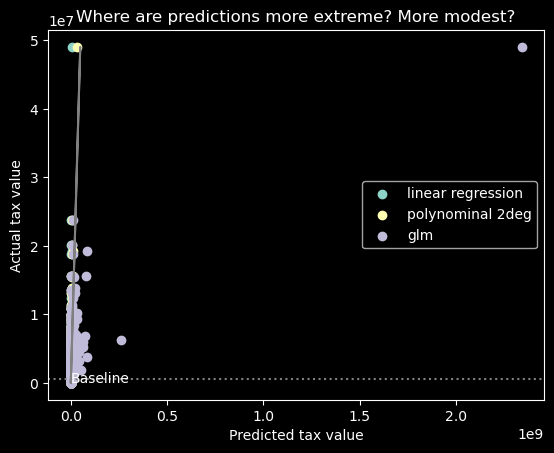

In [255]:
plt.scatter(pred_lr2, y_train, label='linear regression')
plt.scatter(pred_pr, y_train, label='polynominal 2deg')
plt.scatter(pred_glm, y_train, label='glm')
plt.plot(y_train, y_train, label='_nolegend_', color='grey')

plt.axhline(baseline, ls=':', color='grey')
plt.annotate("Baseline", (65, 81))

plt.title("Where are predictions more extreme? More modest?")
plt.ylabel("Actual tax value")
plt.xlabel("Predicted tax value")
plt.legend()

plt.show()

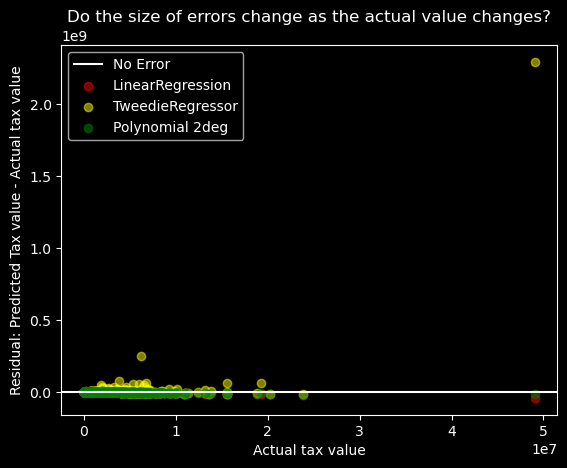

In [256]:
plt.axhline(label="No Error")

plt.scatter(y_train, pred_lr2 - y_train, alpha=.5, color="red", label="LinearRegression")
plt.scatter(y_train, pred_glm - y_train, alpha=.5, color="yellow", label="TweedieRegressor")
plt.scatter(y_train, pred_pr - y_train, alpha=.5, color="green", label="Polynomial 2deg ")

plt.legend()
plt.title("Do the size of errors change as the actual value changes?")
plt.xlabel("Actual tax value")
plt.ylabel("Residual: Predicted Tax value - Actual tax value")

plt.show()